In [2]:
library(Seurat, verbose=F)
library(ggplot2, verbose=F)
library(patchwork, verbose=F)
library(magrittr, verbose=F)
library(data.table, verbose=F)
#设置当前工作目录
setwd('/Users/wjs/Desktop/github/singlecell_notebooks/')

## 数据准备：
Data1: [5k Human PBMCs, 3' v3.1, Chromium Controller](https://www.10xgenomics.com/datasets/5k-human-pbmcs-3-v3-1-chromium-controller-3-1-standard)  
Data2: [10k Human PBMCs, 3' v3.1, Chromium Controller](https://www.10xgenomics.com/datasets/10k-human-pbmcs-3-v3-1-chromium-controller-3-1-high)  
Data3: [10k Human PBMCs, 3' v3.1, Chromium X](https://www.10xgenomics.com/datasets/10k-human-pbmcs-3-ht-v3-1-chromium-x-3-1-high)

SeuratData包 包含了多个物种和组织的单细胞和空间转录组的数据，可以帮助我们快捷方便地使用这些数据集进行分析，对于不熟悉单细胞RNA测序数据分析的科研人员来说，这些数据也是很好的学习材料。同时，这些数据集还可以用于算法开发、模型评估和性能测试等方面。

这里我们演示一下，用到的数据我们已经下载好了。

In [6]:
#已经注释掉的代码，不需要运行
#suppressMessages(library(SeuratData, verbose=F))

#查看可用的数据集
#SeuratData::AvailableData()

#查看已安装的数据集
#InstalledData()
#安装数据集
#InstallData('stxBrain')

#### 读取数据：

In [22]:
sce <- Read10X('data/Data1/filtered_feature_bc_matrix/')

In [23]:
#sce <- Read10X_h5('data/Data1/filtered_feature_bc_matrix.h5')

In [24]:
sce <- CreateSeuratObject(counts = sce, min.cells = 10, min.features = 200, assay = "RNA")

In [25]:
class(sce)

[1] "Seurat"
attr(,"package")
[1] "SeuratObject"

## 细胞过滤

单细胞测序数据中的线粒体基因占比可以反映细胞的代谢状态和健康状况。如果细胞代谢状态不良或线粒体功能受损，线粒体基因的表达量会增加，从而使得线粒体基因占比增加或者细胞膜破裂导致RNA流出等。因此，通过过滤线粒体基因占比高的细胞，可以排除代谢状态不良或线粒体受损的细胞，提高单细胞测序数据的质量和准确性。

单细胞测序数据中过滤掉核糖体RNA的主要原因是，核糖体RNA（rRNA）在细胞中的丰度非常高，占据了大部分的RNA分子，而且它们的序列高度保守，很难区分不同细胞之间的差异，因此会干扰到单细胞测序数据的质量和准确性。此外，rRNA也不包含有关细胞类型和状态的信息，因此过滤掉rRNA可以提高单细胞测序数据的信噪比，剔除由于细胞活跃度不同而导致的表达值差异，使得后续的数据分析更加准确和有意义。

单细胞测序数据UMI数过高的细胞应该过滤掉，因为这可能是由于细胞裂解或PCR扩增等技术问题导致的假阳性。过滤的阈值可以根据实验设计和分析目的来确定，一般建议不超过总细胞数的5%。

UMI数过低的细胞也可以考虑过滤掉，因为这可能是由于细胞裂解不完全或RNA含量低等因素导致的。过滤的阈值也可以根据实验设计和分析目的来确定，一般建议保留UMI数大于100的细胞。

计算线粒体和核糖体基因占比

计算线粒体基因和核糖体基因所占比例，可以选择过滤掉部分细胞，这里我们不做其他的过滤了

In [26]:
sce <- PercentageFeatureSet(object = sce, pattern = "^MT|^mt",col.name = "percent.mt")
sce <- PercentageFeatureSet(object = sce, pattern = "^R[Pp][slSL]",col.name = "percent.ribo")

In [27]:
head(sce@meta.data)

orig.ident    nCount_RNA nFeature_RNA percent.mt
AAACCCATCAGATGCT-1 SeuratProject 11463      3328         3.89077903
AAACGAAAGTGCTACT-1 SeuratProject  5618      1942         4.50338199
AAACGAAGTCGTAATC-1 SeuratProject 14717       235         0.02717945
AAACGAAGTTGCCAAT-1 SeuratProject 10829      2952         5.04201681
AAACGAATCCGAGGCT-1 SeuratProject  6106      2269         0.78611202
AAACGAATCGAACGCC-1 SeuratProject  8061      2976         4.30467684
                   percent.ribo
AAACCCATCAGATGCT-1 26.0751985  
AAACGAAAGTGCTACT-1 40.3346387  
AAACGAAGTCGTAATC-1  0.2446151  
AAACGAAGTTGCCAAT-1 37.3256995  
AAACGAATCCGAGGCT-1 28.4146741  
AAACGAATCGAACGCC-1 20.1960055

下面我们对图片做一下改动，主要是改动了标题（title），以及x轴标签，排列方式也做了更改

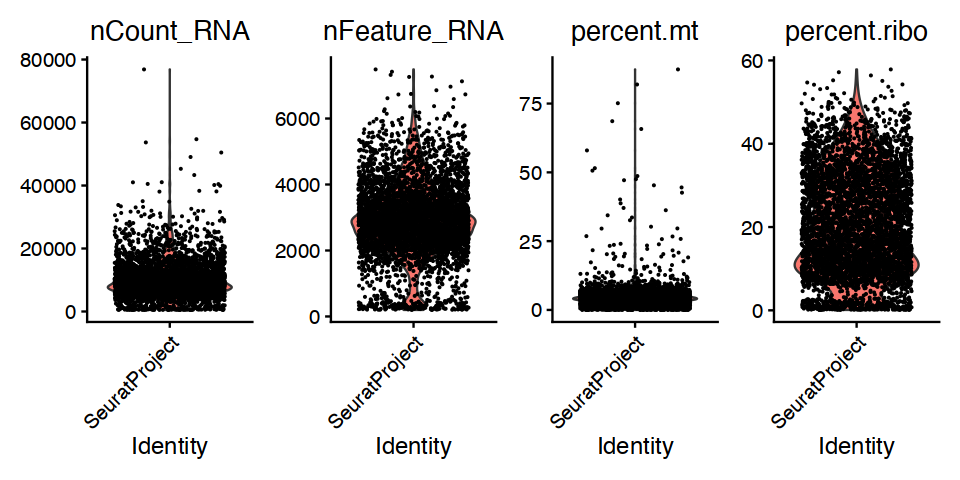

In [28]:
options(repr.plot.width=8, repr.plot.height=4)
vln <- VlnPlot(sce, group.by = "orig.ident",
               features = c("nCount_RNA","nFeature_RNA","percent.mt", 'percent.ribo'),
               assay = "RNA", layer='counts', ncol=4)
               
vln

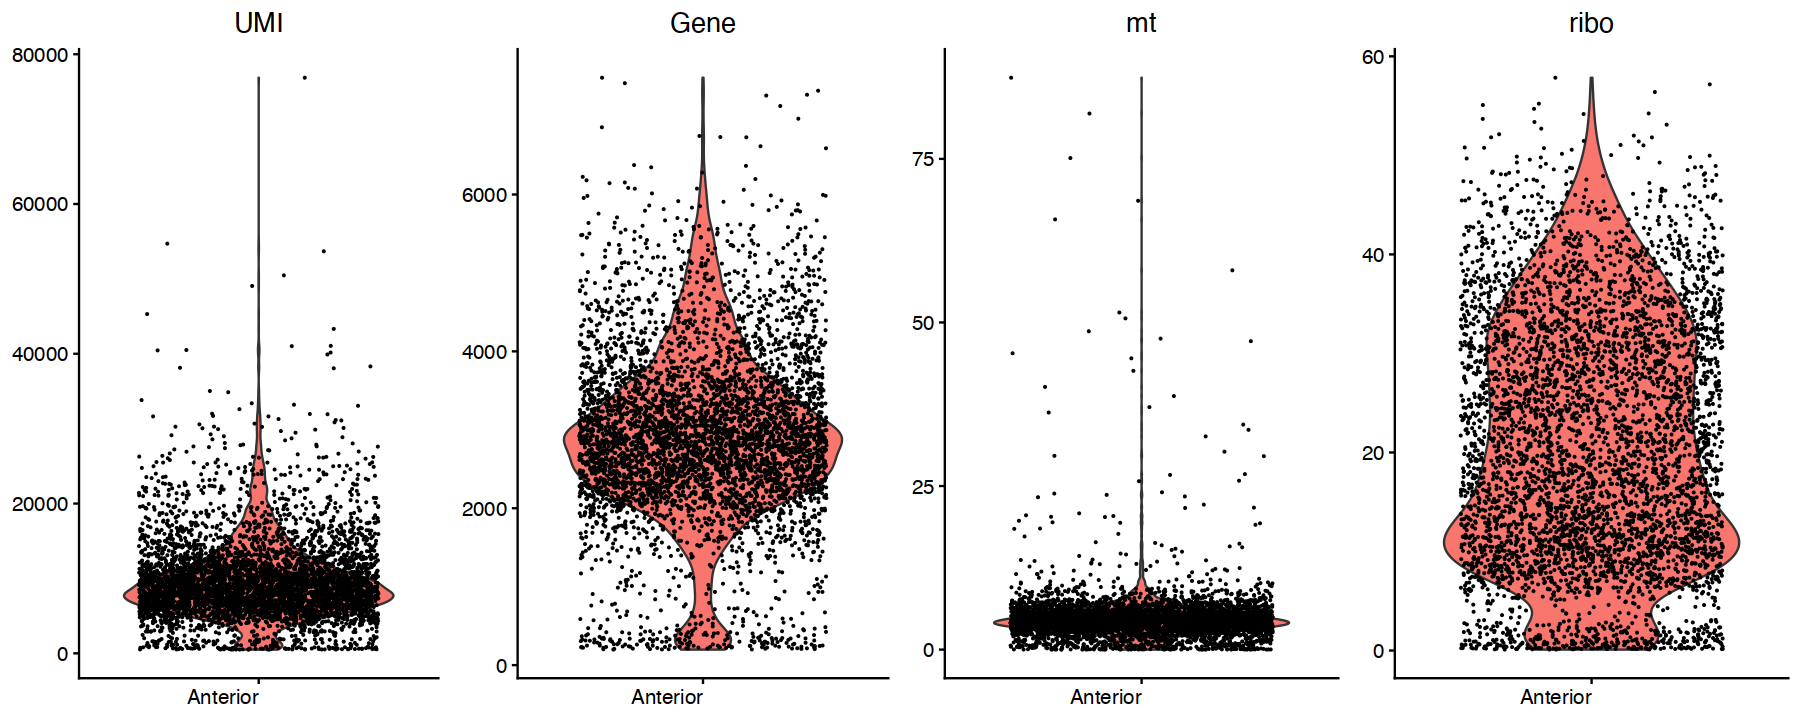

In [29]:
title_list=list("UMI","Gene","mt", 'ribo')
xlab_list = rep("Anterior", 4)
newvln=lapply(1:4,function(x){
      vln[[x]]+labs(title = title_list[x])+scale_x_discrete(labels=xlab_list[x])+
        theme(axis.title.x.bottom = element_blank(),
              axis.text.x.bottom = element_text(angle = 0),
              legend.position = "none",
              legend.title = element_blank()
        )
    })
vln_nofilter=cowplot::plot_grid(plotlist = newvln,ncol = 4)
options(repr.plot.width=15, repr.plot.height=6)
vln_nofilter

下面我们展示一下图片的排列方式，我们大概看一下几种组合情况，这是用patchwork包实现的，功能非常的强大，可以实现各种组合形式，感兴趣的老师在课后可以多尝试几种组合试试，我们就不把时间过多的花在这里了

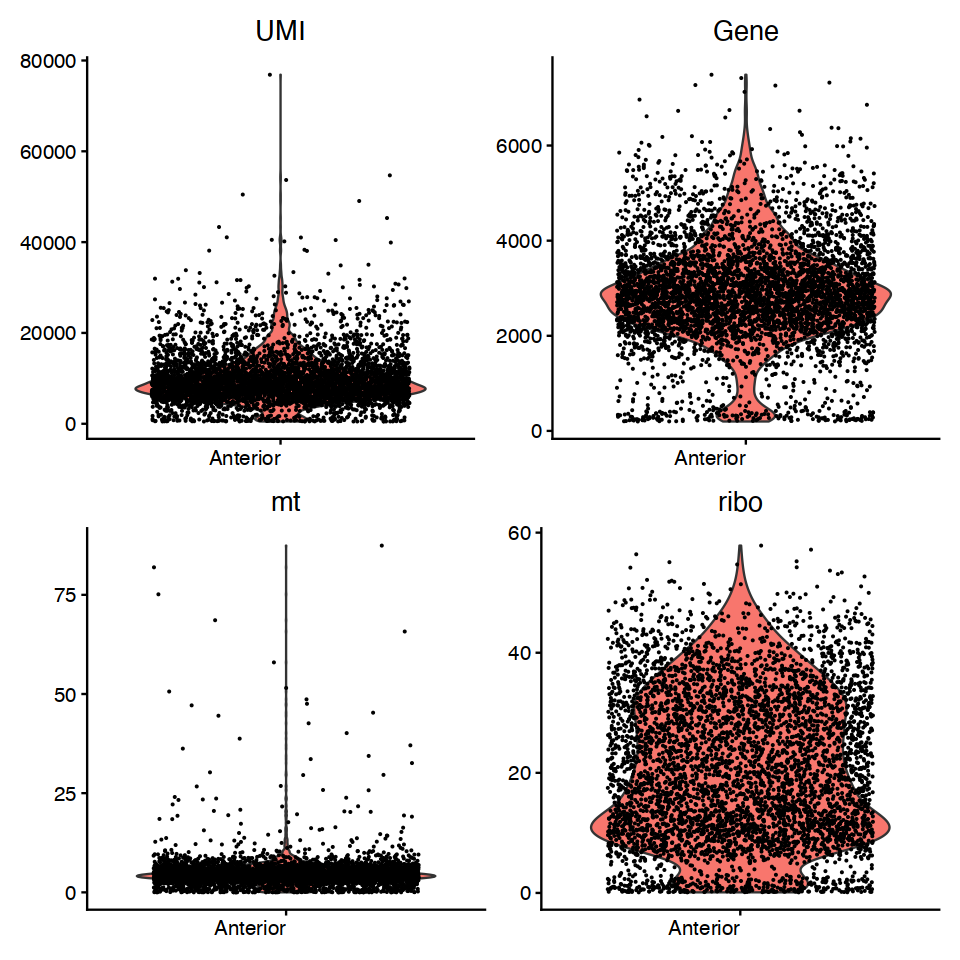

In [30]:
options(repr.plot.width=8, repr.plot.height=8)
(newvln[[1]] | newvln[[2]]) / (newvln[[3]] | newvln[[4]])

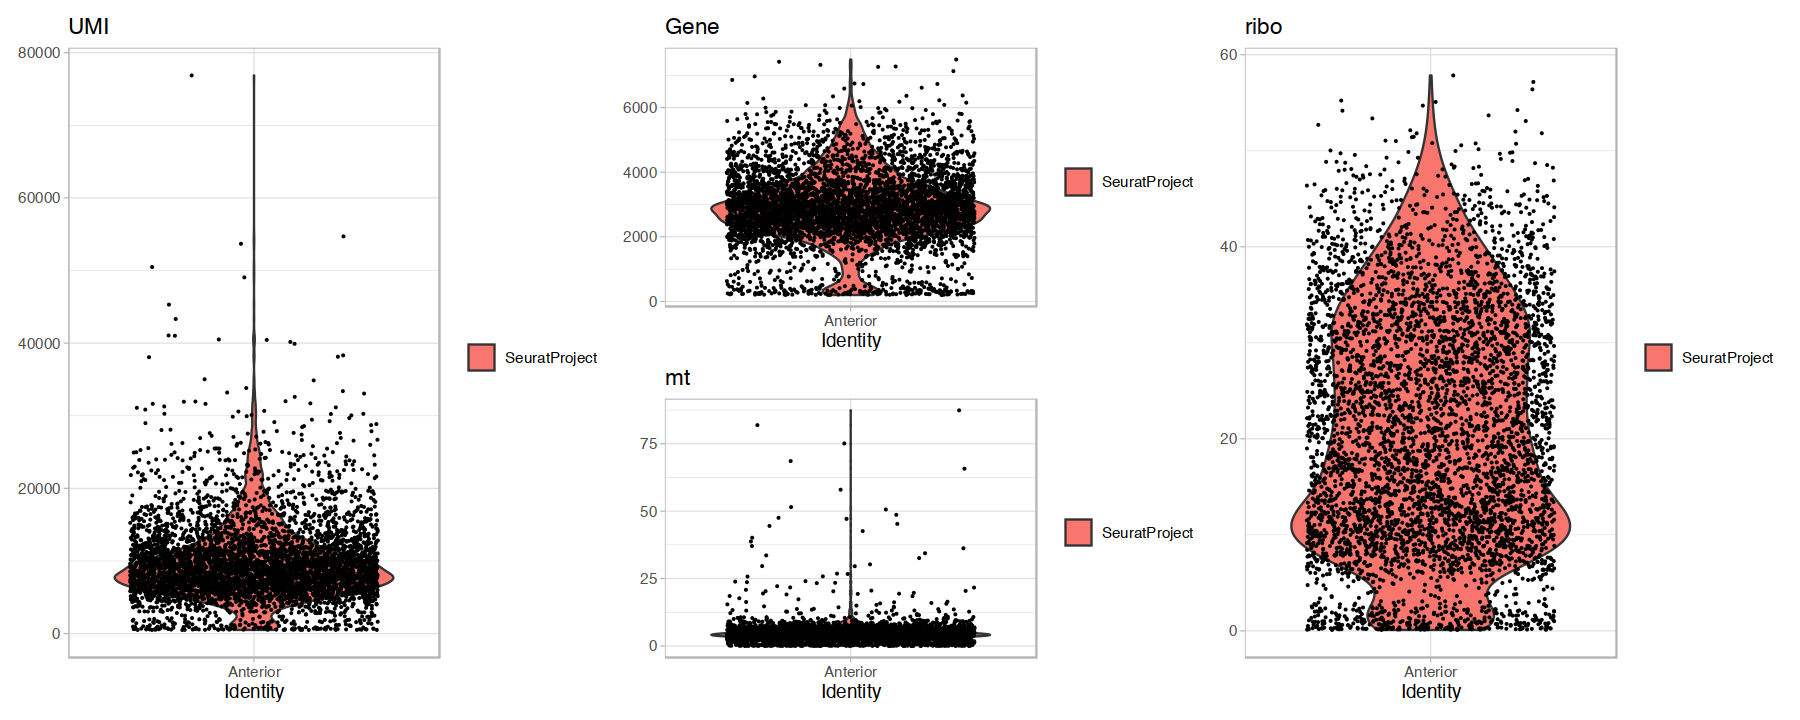

In [31]:
options(repr.plot.width=15, repr.plot.height=6)
newvln[[1]] + (newvln[[2]] / newvln[[3]]) + newvln[[4]] & theme_light()

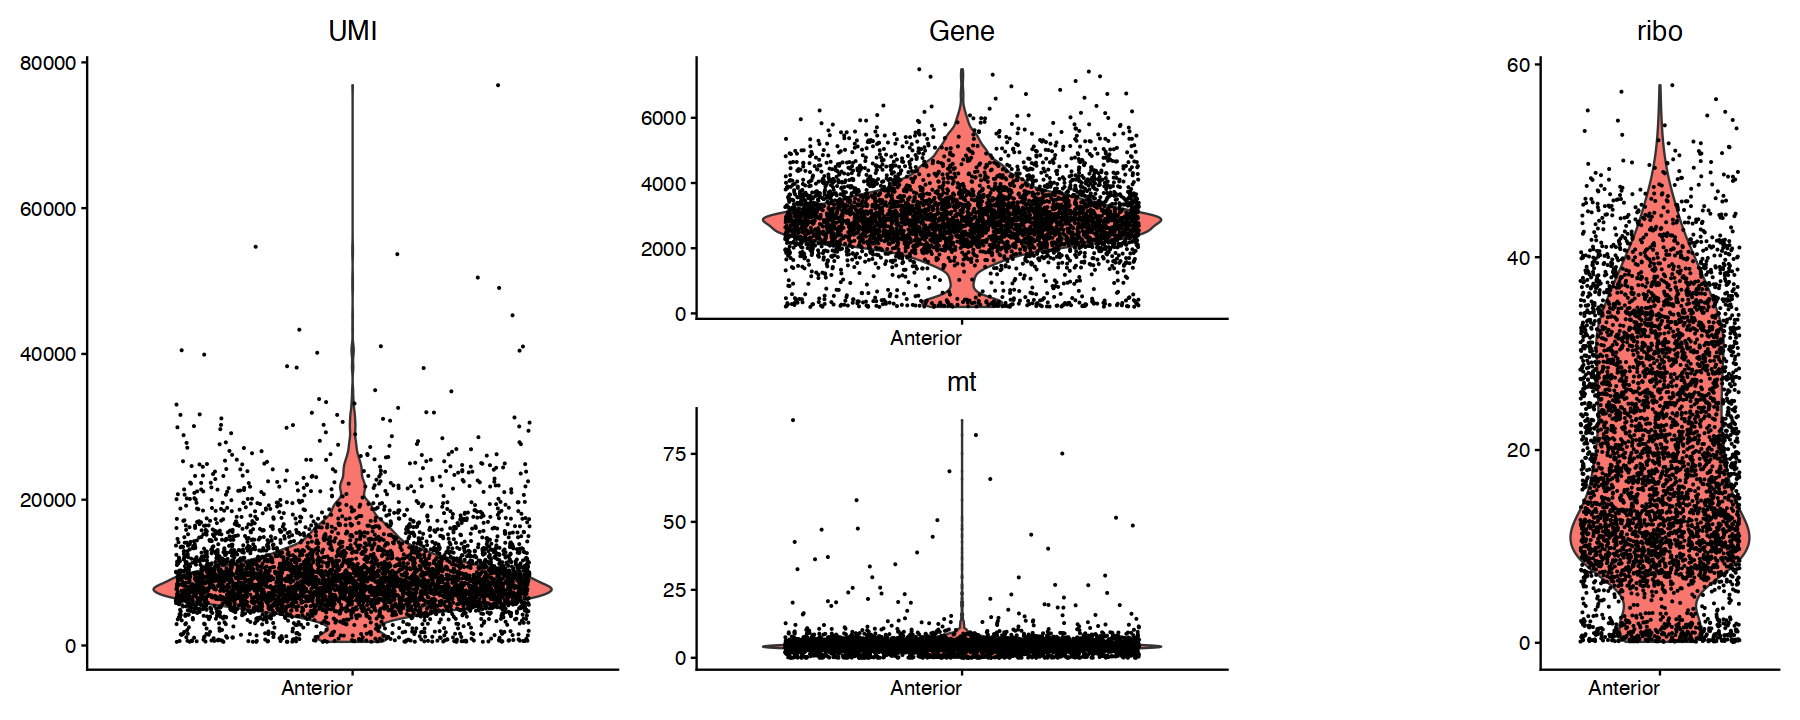

In [32]:
newvln[[1]] + (newvln[[2]] / newvln[[3]]) + (plot_spacer() + newvln[[4]] + plot_layout(ncol=2, widths = c(1,1)))

[1] -0.202449

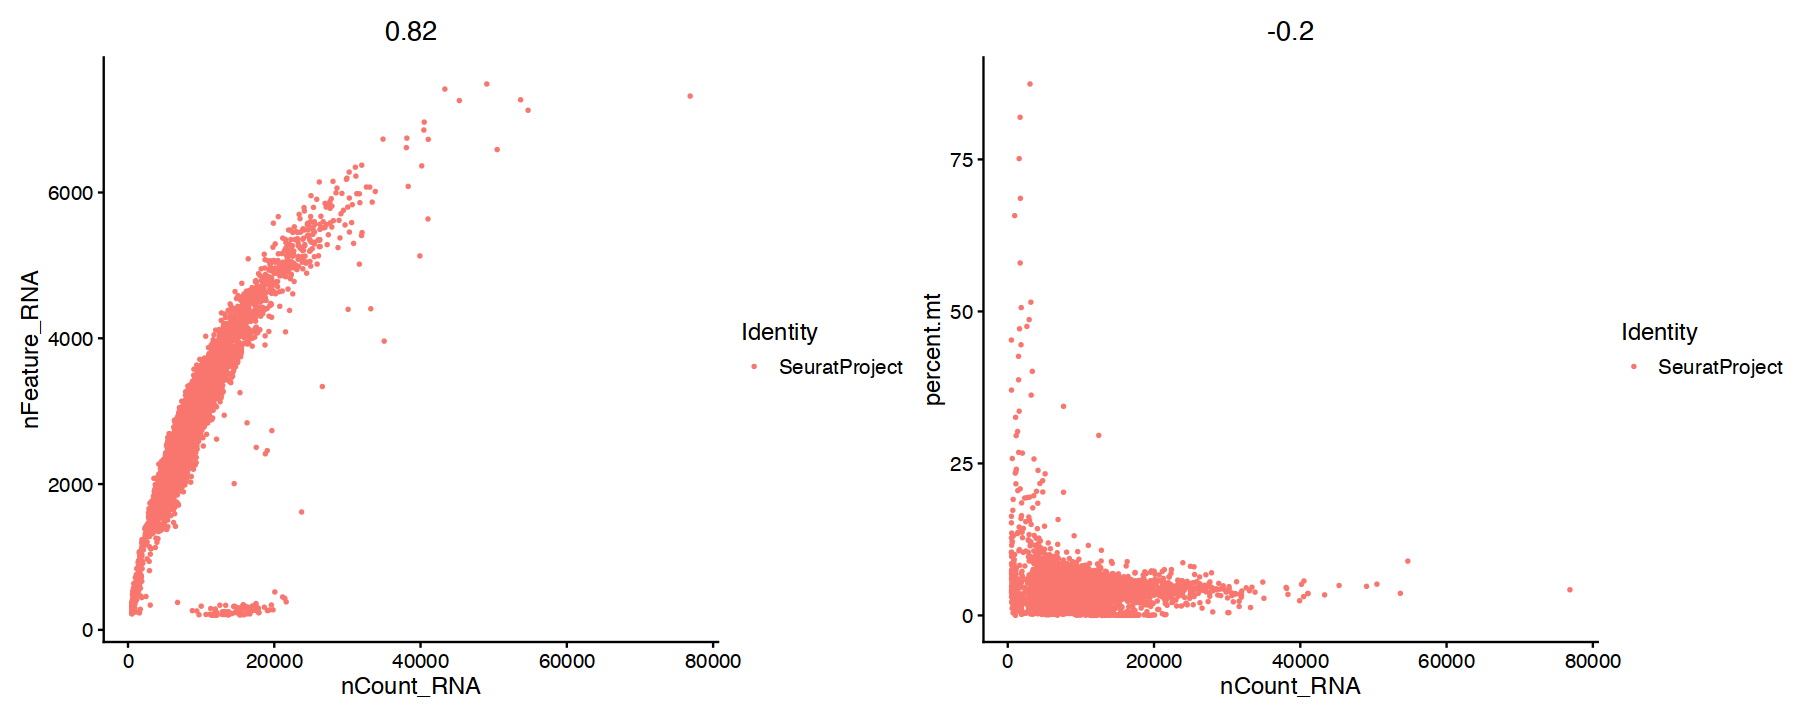

In [33]:
p1 <- FeatureScatter(sce, "nCount_RNA", "nFeature_RNA", group.by = "orig.ident", pt.size = 0.5)
p2 <- FeatureScatter(sce, "nCount_RNA", "percent.mt", group.by = "orig.ident", pt.size = 0.5)
cor(sce$nCount_RNA, sce$percent.mt,method = "pearson")
p1 + p2

In [34]:
genes <- grep("^R[Pp][slSL]", rownames(sce), invert=T)

In [35]:
sce <- subset(sce, subset=percent.mt<=10 & percent.ribo<=40, features=genes)

In [36]:
dim(sce)

[1] 19367  4420

# 数据处理过程

#### 标准化

在单细胞或空间转录组测序数据中经常观察到文库之间测序覆盖率的系统性差异（Stegle、Teichmann和Marioni，2015）。它们通常源于细胞间cDNA捕获或PCR扩增效率的技术差异，这归因于难以用最少的起始材料实现一致的文库制备。标准化旨在消除这些差异，使它们不会干扰细胞之间表达谱的比较。这确保了在细胞群体中观察到的任何异质性或差异表达都是由生物学而非技术偏倚造成的。

用函数NormalizeData，具体计算方法可以用下面的公式表示
$$
\begin{aligned}
stepA =& \frac{\text{UMI of Gene}}{\text{Total UMI}} \times \text{ScaleFactor} \\
\\
stepB =& \log(stepA + 1)
\end{aligned}
$$

ScaleFactor在函数NormalizeData中的默认值是10000，实际上我们可以看到在乘以ScaleFactor之前就是每个基因在每个细胞中的相对表达量。

In [37]:
# 默认的assay，实际上就是表达数据存的地方
DefaultAssay(sce)

[1] "RNA"

In [38]:
quantile(colSums(sce@assays$RNA@layers$counts))

0%     25%     50%     75%    100% 
  493.0  5162.0  6966.0  9844.5 60458.0

In [39]:
sce <- NormalizeData(sce, verbose=F)

In [40]:
#获得的数据存储来data slot中，我们可以逆向计算一下看看
colSums(exp(sce@assays$RNA@layers$data)-1)[1:10]

[1] 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000

In [41]:
head(sce@meta.data)

orig.ident    nCount_RNA nFeature_RNA percent.mt
AAACCCATCAGATGCT-1 SeuratProject  8474      3244         3.89077903
AAACGAAGTCGTAATC-1 SeuratProject 14681       211         0.02717945
AAACGAAGTTGCCAAT-1 SeuratProject  6787      2868         5.04201681
AAACGAATCCGAGGCT-1 SeuratProject  4371      2185         0.78611202
AAACGAATCGAACGCC-1 SeuratProject  6433      2894         4.30467684
AAACGAATCGCCTTGT-1 SeuratProject  7559      2854         4.90651792
                   percent.ribo
AAACCCATCAGATGCT-1 26.0751985  
AAACGAAGTCGTAATC-1  0.2446151  
AAACGAAGTTGCCAAT-1 37.3256995  
AAACGAATCCGAGGCT-1 28.4146741  
AAACGAATCGAACGCC-1 20.1960055  
AAACGAATCGCCTTGT-1 21.9192232

In [42]:
dim(sce@assays$RNA@layers$counts)

[1] 19367  4420

#### 获取高可变基因

我们经常在探索性分析中使用scRNA-seq数据来表征细胞间的异质性。聚类和降维等根据细胞的基因表达谱对细胞进行比较，包括将所有基因的差异聚合为一对细胞之间的相似性度量。在这种计算中所使用的基因对相似性度量和下游方法的性能有很大影响。我们希望选择包含生物学信息的基因，同时去除包含随机噪声的基因。这旨在保持有趣的生物结构，而不会出现模糊该结构的变异，并减少数据的大小，以提高后续步骤的计算效率。当然，最简单的特征选择方法是根据基因在群体中的表达来选择变化最大的基因，这里假设了真正的生物差异是远大于仅受技术噪音影响的其他基因。

In [43]:
# 数据存储在var.features中
sce <- FindVariableFeatures(sce, nfeatures = 2000, selection.method='vst')

Finding variable features for layer counts



#### 选择基因的方法vst

FindVariableFeatures函数有个参数selection.method='vst'，这是具体计算和筛选高可变基因的方法，具体操作为：首先拟合对数-均值和对数方差的关系曲线，以实际的对数均值和拟合的对数方差进行标准化，再计算标准差，以此标准差筛选高可变基因。
实际上这样的处理应该是基于这样的假设：在任何表达水平下，大部分基因表现出来的差异都是由随机噪音造成的。在这样的假设下，拟合的曲线上的值代表了对我们不感兴趣的原因导致的差异，我们可以称之为技术成分导致的变异。总的变异减去变异的技术成分得到的就是生物学原因导致的变异，用这部分变异来筛选高可变基因就十分的合理了。

我们可以直观的看一下：

In [44]:
tmp = sce@assays$RNA@meta.data

In [45]:
head(tmp)

vf_vst_counts_mean vf_vst_counts_variance vf_vst_counts_variance.expected
1 0.006787330        0.006742788            0.008411762                    
2 0.022624434        0.022570164            0.032121695                    
3 0.264705882        0.522356668            0.431660764                    
4 0.066742081        0.076784586            0.099703616                    
5 0.027828054        0.029775322            0.040000568                    
6 0.008371041        0.008302845            0.010649567                    
  vf_vst_counts_variance.standardized vf_vst_counts_variable vf_vst_counts_rank
1 0.8015904                           FALSE                  NA                
2 0.7026455                           FALSE                  NA                
3 1.2101092                           FALSE                  NA                
4 0.7701284                           FALSE                  NA                
5 0.7443725                           FALSE                  NA                
6 0.7796416                           FALSE                  NA                
  var.features var.features.rank
1 NA           NA               
2 NA           NA               
3 NA           NA               
4 NA           NA               
5 NA           NA               
6 NA           NA

In [46]:
tmp$hvar <- ifelse(tmp$vf_vst_counts_variable, 'red', 'green')

In [47]:
options(repr.plot.width=8, repr.plot.height=5)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 60 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 60 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_smooth()`).”


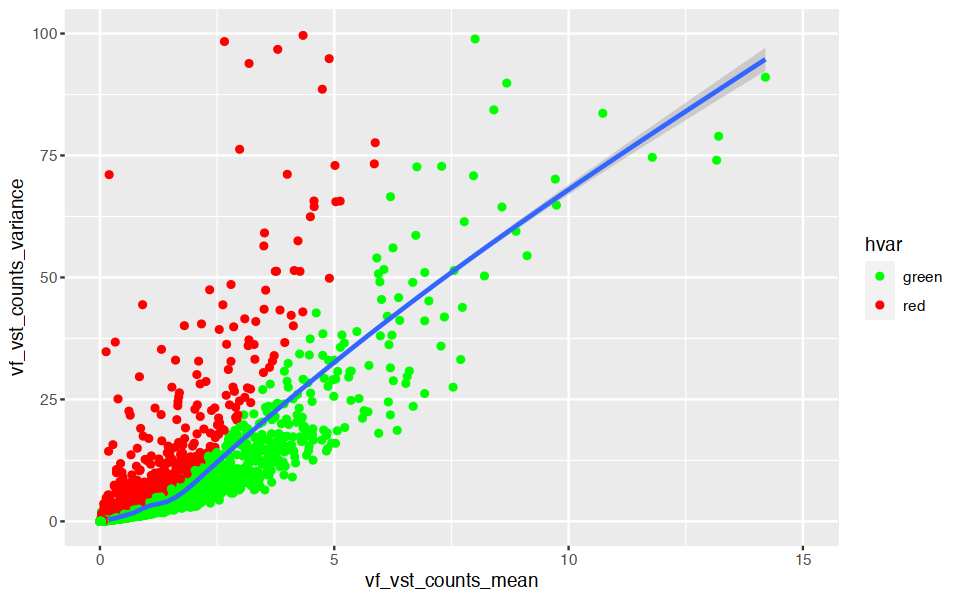

In [48]:
ggplot(tmp, aes(x=vf_vst_counts_mean, y=vf_vst_counts_variance)) +
      geom_point(aes(color=hvar))+ xlim(0, 15)+ylim(0, 100) + 
      scale_color_manual(values=c(green='green', red='red'))+
      geom_smooth()

Warning message:
“Removed 47 rows containing missing values (`geom_point()`).”


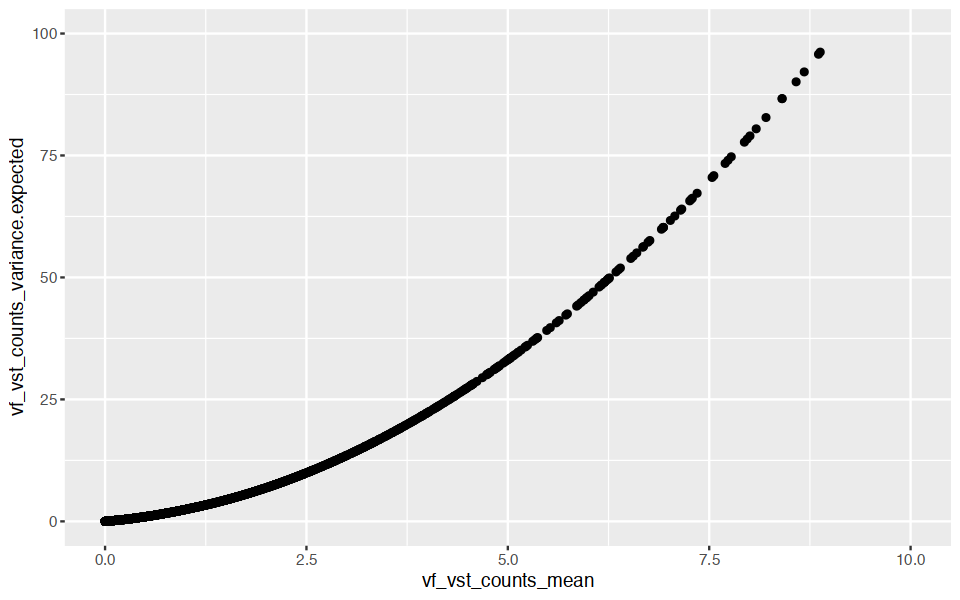

In [49]:
ggplot(tmp, aes(x=vf_vst_counts_mean, y=vf_vst_counts_variance.expected)) +
      geom_point()+ xlim(0, 10)+ylim(0, 100)

Warning message:
“Removed 42 rows containing missing values (`geom_point()`).”


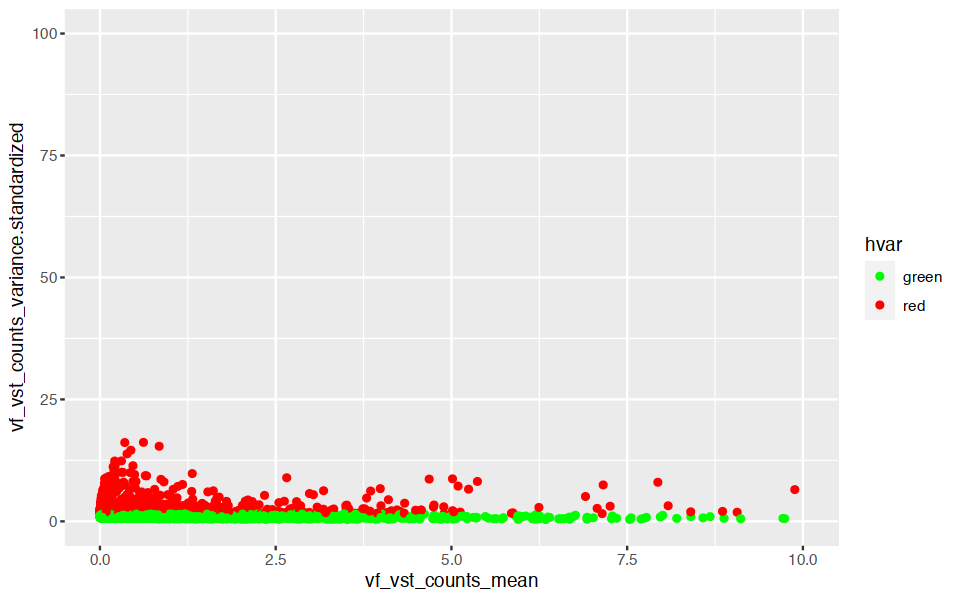

In [50]:
ggplot(tmp, aes(x=vf_vst_counts_mean, y=vf_vst_counts_variance.standardized)) +
      geom_point(aes(color=hvar))+ xlim(0, 10)+ylim(0, 100) +# scale_x_log10()+
      scale_color_manual(values=c(green='green', red='red'))

#### 选择基因的数量
更大的子集将通过保留更多潜在的相关基因来降低丢弃感兴趣的生物信号的风险，代价是增加来自可能掩盖所述信号的不相关基因的噪声。很难确定任何给定应用的最佳权衡，因为一种情况下的噪声在另一种情况中可能是有用的信号。
n是相当任意的，从500到5000的任何值都被认为是“合理的”。我们的建议是简单地选择一个任意的n，然后继续进行其余的分析，目的是稍后测试其他选择，而不是花很多时间担心获得“最优”值。

#### 归一化与中心化
对数据进行归一化和中心化（就是减去均值，除以标准差），可以用于后续的PCA以及热图等。

In [51]:
sce <- ScaleData(sce, verbose=F)

### SCTransform

SCTransform是Seurat3中引入的数据转换方法，作为NormalizeData, ScaleData和FindVariableFeatures替代选项。其主要思想就是以负二项回归去除一些影响转录本计数的因素。处理方式上看着更合理，同时运行时间也多。这里我们就不做过多的讲解了，感兴趣的老师可以查看帮助文档或者参考这篇微信推文：[这就是SCTransform?](https://mp.weixin.qq.com/s?__biz=Mzg5OTI1ODQyOA==&mid=2247483675&idx=1&sn=1b986d6effaeaf944ff4687a29304333&chksm=c0574048f720c95ef01e9a4f8aa9beb39bfef95129c10340df49c7cbe9e0015242d55e8f00cd#rd)。

In [92]:
sce <- SCTransform(sce, assay = 'RNA', verbose=F) #  method = "glmGamPoi"

Warning message:
“multiple methods tables found for ‘aperm’”
Warning message:
“replacing previous import ‘BiocGenerics::aperm’ by ‘DelayedArray::aperm’ when loading ‘SummarizedExperiment’”


In [93]:
DefaultAssay(sce)

[1] "SCT"

### PCA

主成分分析是通过寻找原始数据集中的最大方差方向，来发现数据内在变化模式的技术。主成分分析通过对数据进行线性变换，并保留最多信息的前几个新变量（称为主成分），以实现数据压缩和可视化等应用。具体而言，主成分分析将原始数据投影到一个新坐标系中，使得第一主成分沿着数据变化的方向可以最大程度地解释数据的方差，第二主成分垂直于第一主成分并解释尽可能多的剩余方差，第三主成分垂直于前两个主成分并解释更多的剩余方差，以此类推。一般而言，我们只选择保留能够解释总方差一定比例的主成分数量作为降维后的特征空间。

In [52]:
sce <- RunPCA(sce, npcs = 30, verbose = F)

In [53]:
sce@reductions

$pca
A dimensional reduction object with key PC_ 
 Number of dimensions: 30 
 Number of cells: 4420 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 


Warning message in ElbowPlot(sce, ndims = 50, reduction = "pca"):
“The object only has information for 30 reductions”


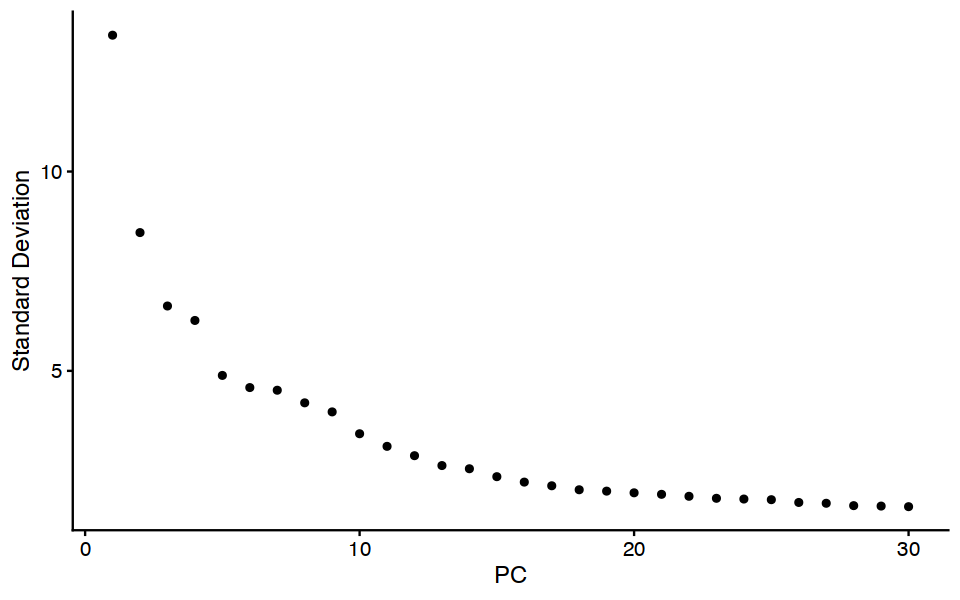

In [54]:
ElbowPlot(sce, ndims = 50, reduction = "pca")

#### 聚类及可视化
当我们进行单细胞RNA测序时，通常需要将高维的数据转化为二维或三维图示来方便可视化和分析。t-SNE和UMAP是两种比较常用的降维算法，它们都可以将高维的数据映射至低维空间上。  
这里的可以用于后面的TSNE和UMAP的可视化。

In [55]:
sce <- RunTSNE(sce, verbose=F)
sce <- RunUMAP(sce, dims=1:30, verbose=F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [56]:
# 结果存储在reductions里
sce@reductions

$pca
A dimensional reduction object with key PC_ 
 Number of dimensions: 30 
 Number of cells: 4420 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 

$tsne
A dimensional reduction object with key tSNE_ 
 Number of dimensions: 2 
 Number of cells: 4420 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 

$umap
A dimensional reduction object with key umap_ 
 Number of dimensions: 2 
 Number of cells: 4420 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 


In [57]:
sce <- FindNeighbors(sce, k.param = 20, verbose = F)

#计算结果是存储在graphs中
names(sce@graphs)

[1] "RNA_nn"  "RNA_snn"

In [58]:
sce <- FindClusters(sce, resolution = 0.2, algorithm = 1, verbose = F)

In [59]:
unique(sce$seurat_clusters)

[1] 0  8  5  4  3  2  6  1  9  7  10
Levels: 0 1 2 3 4 5 6 7 8 9 10

In [60]:
head(sce@meta.data)

orig.ident    nCount_RNA nFeature_RNA percent.mt
AAACCCATCAGATGCT-1 SeuratProject  8474      3244         3.89077903
AAACGAAGTCGTAATC-1 SeuratProject 14681       211         0.02717945
AAACGAAGTTGCCAAT-1 SeuratProject  6787      2868         5.04201681
AAACGAATCCGAGGCT-1 SeuratProject  4371      2185         0.78611202
AAACGAATCGAACGCC-1 SeuratProject  6433      2894         4.30467684
AAACGAATCGCCTTGT-1 SeuratProject  7559      2854         4.90651792
                   percent.ribo RNA_snn_res.0.2 seurat_clusters
AAACCCATCAGATGCT-1 26.0751985   0               0              
AAACGAAGTCGTAATC-1  0.2446151   8               8              
AAACGAAGTTGCCAAT-1 37.3256995   0               0              
AAACGAATCCGAGGCT-1 28.4146741   5               5              
AAACGAATCGAACGCC-1 20.1960055   4               4              
AAACGAATCGCCTTGT-1 21.9192232   5               5

##### algorithm参数
algorithm默认的是louvain算法：
Louvain算法是一种社区聚类算法。社区聚类算法的目标是将网络（或图）中相似的节点划分到同一个社区，使社区之间的差异尽可能大，并且内部联系尽可能紧密。
Louvain算法通过最大化模块度来实现这个目标，即将网络划分为不同的社区，使得社区内部节点连接更加紧密，而社区之间的连接比较稀疏。在Louvain算法中，每个节点被视为一个社区，然后迭代地合并相邻的社区，直到找到了最大的模块度。每次迭代都包含两个步骤：

1. 对于每个节点，计算它与它所在社区以及所有相邻社区的模块度增益。将该节点加入可以提高模块度的社区；  
2. 重复第一步，直到没有进一步的模块度增益

此后，我们已经找到了一个社区分配，其中模块度最大化，从而揭示了网络的社区结构。值得注意的是，Louvain算法是一种贪心算法，因此不能保证找到全局最优解。但是，在实践中，它已被证明可以快速而准确地发现大多数真实世界中网络的社区结构。
algorithm=4时，使用leiden算法，leiden算法是对louvain算法做了改进，这里我们还是选择用Louvain算法，因为leiden需要依赖于leidenalg的python模块。

##### resolution参数
当 resolution 较低时，聚类的数量可能较少；而当 resolution 较高时，可以得到更多、更小的细分群体。需要注意的是，增加 resolution 参数的值会使得计算时间和内存占用量增加。同时也需要谨慎处理过高的 resolution 参数值，因为它可能导致对噪音和技术等非生物学因素敏感的过度细分。

#### 可视化

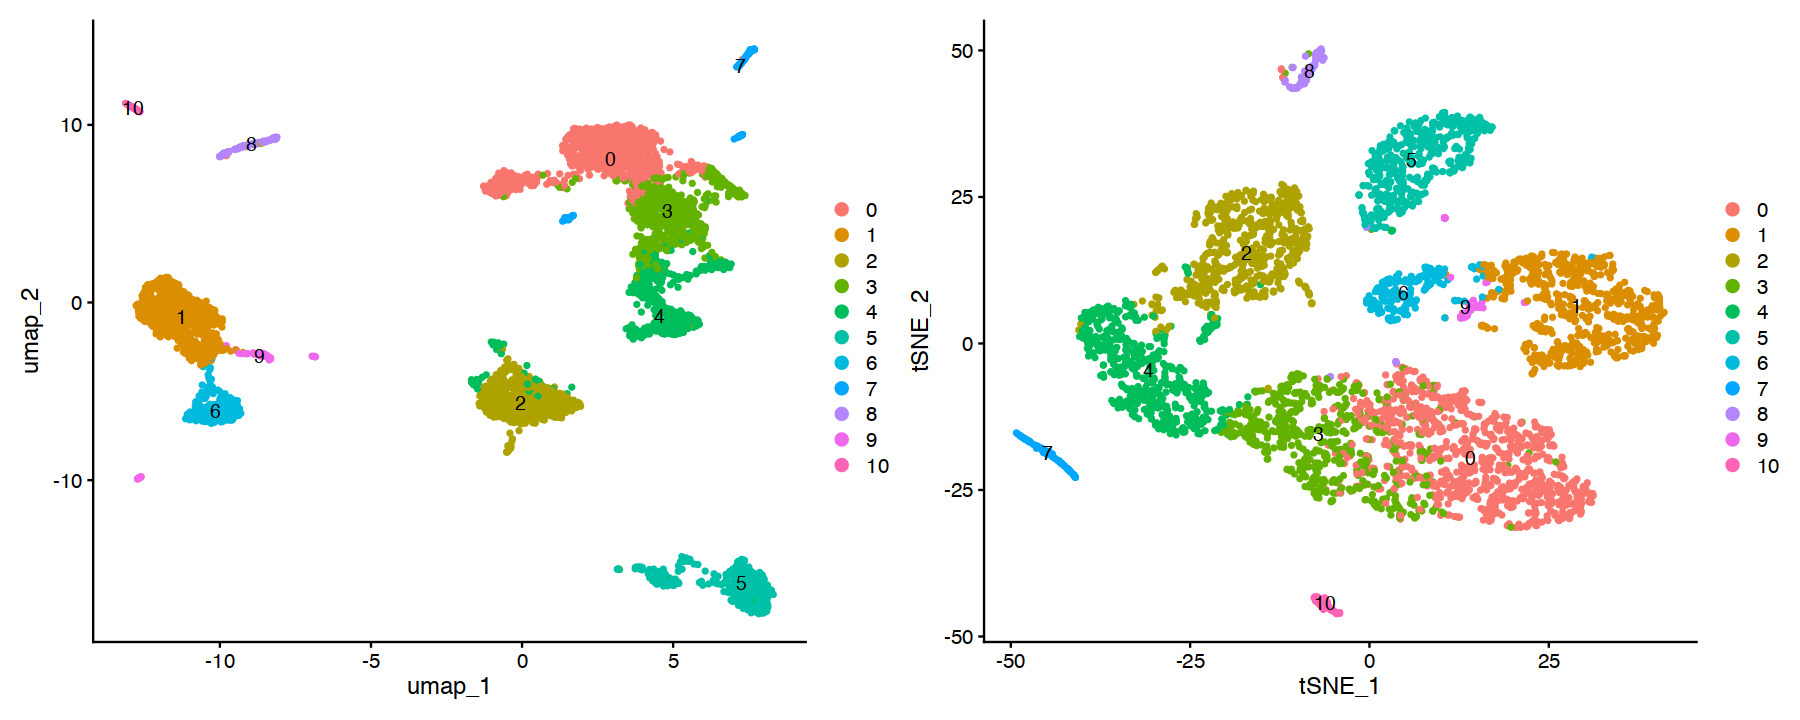

In [67]:
options(repr.plot.width=15, repr.plot.height=6)
p1 <- DimPlot(sce, reduction = 'umap', label=T, pt.size=1)
p2 <- DimPlot(sce, reduction = 'tsne', label=T, pt.size=1)
p1+p2

## Marker基因鉴定
在bulk RNA实验中，我们首先想到的就是查看不同条件下的差异表达基因，因此也出现了edgeR和DESeq2等优秀的工具。单细胞RNA所关注的问题与bulk RNA是有一些微妙的不同，bulk RNA-seq实验中的差异表达基因代表了大量细胞在条件之间的总表达水平的差异，这种差异可能是细胞类型占比导致的。单细胞RNA更关注的是哪些基因在一组细胞中表达，另一组细胞中不表达，并且可以直接看到细胞类型的占比。

In [58]:
df <- FindAllMarkers(sce, test.use = "wilcox", min.pct = 0.5,
                     logfc.threshold = 0.8, slot = "data",
                     verbose = F, assay = 'RNA')

head(df)

p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene      
S100A12    0     2.934612   0.978 0.385 0         0       S100A12   
CD14       0     1.755489   0.952 0.444 0         0       CD14      
VCAN       0     2.407363   0.995 0.495 0         0       VCAN      
CSF3R      0     1.815052   0.903 0.446 0         0       CSF3R     
MEGF9      0     2.043171   0.840 0.416 0         0       MEGF9     
AC020656.1 0     1.718431   0.975 0.553 0         0       AC020656.1

参数解析：
* test.use = "wilcox": 用于假设检验的方法，wilcox是比较常见，也是默认的方法，不依赖总体分布，适应范围广，运行速度相对较快
* min.pct = 0.5：表达比例大于0.5的基因才会用于假设检验，可以减少运算量
* logfc.threshold=0.8: logFC大于0.8基因才会用于假设检验，可以减少运算量

In [57]:
dfc1c2 <- FindMarkers(sce, ident.1=1,
                      ident.2=2, logfc.threshold = 0.5,
                      test.use = "wilcox", min.pct = 0.2,
                      verbose = F)

In [58]:
head(dfc1c2)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
PLXDC2 1.868171e-250 -9.837895  0.017 0.994 3.636021e-246
CSF3R  4.346329e-249 -8.678409  0.016 0.991 8.459261e-245
LYN    7.144654e-248 -8.139743  0.047 0.995 1.390564e-243
VCAN   1.238048e-247 -9.730025  0.031 0.991 2.409612e-243
IRAK3  9.783309e-246 -8.043017  0.026 0.986 1.904125e-241
FCN1   2.298953e-245 -7.917714  0.039 0.988 4.474452e-241

参数解析：
* ident.1=1, ident.2=2：指定cluster，logFC是 ident.1/ident.2
* cells.1 = NULL, cells.2 = NULL：也可以直接指定两组细胞的barcode，以barcode向量指定

```
# 查找cluster 5的marker基因，这里是cluster 5 与其他所有细胞相比
FindMarkers(sce, ident.1=5, logfc.threshold = 0.5, test.use = "wilcox", min.pct = 0.2)
```

这里我们稍微介绍一下data.table包：
data.table包是R语言中用于处理大型数据集的高效工具包，它提供了一种新的数据结构data.table，可以快速地进行数据操作和计算，特别适合于需要进行大规模数据操作和计算的数据分析任务，能够提高数据处理的效率和速度。`help(data.table)`可以看到非常详细的教程，在这里我们就不详细介绍了，有兴趣的可以自己查看。

In [60]:
mks <- data.table(df)[order(cluster, -avg_log2FC), head(.SD, 10), by=c("cluster")]

In [61]:
head(mks)

cluster p_val         avg_log2FC pct.1 pct.2 p_val_adj     gene     
1 0        0.000000e+00 3.309963   0.952 0.196  0.000000e+00 LEF1     
2 0       2.094461e-260 3.209183   0.532 0.088 4.076450e-256 LINC01550
3 0        0.000000e+00 3.208544   0.736 0.122  0.000000e+00 CCR7     
4 0       5.374475e-267 3.166126   0.532 0.080 1.046034e-262 AK5      
5 0        0.000000e+00 3.014333   0.746 0.140  0.000000e+00 TRABD2A  
6 0       6.027902e-225 2.940285   0.531 0.106 1.173211e-220 TSHZ2

In [63]:
sce@misc$marker_res0.2 <- mks

In [64]:
sce@misc$marker_res0.2_all <- df

In [65]:
mks[cluster==0]$gene

[1] "LEF1"      "LINC01550" "CCR7"      "AK5"       "TRABD2A"   "TSHZ2"    
 [7] "NELL2"     "RETREG1"   "PRKCQ-AS1" "MAL"

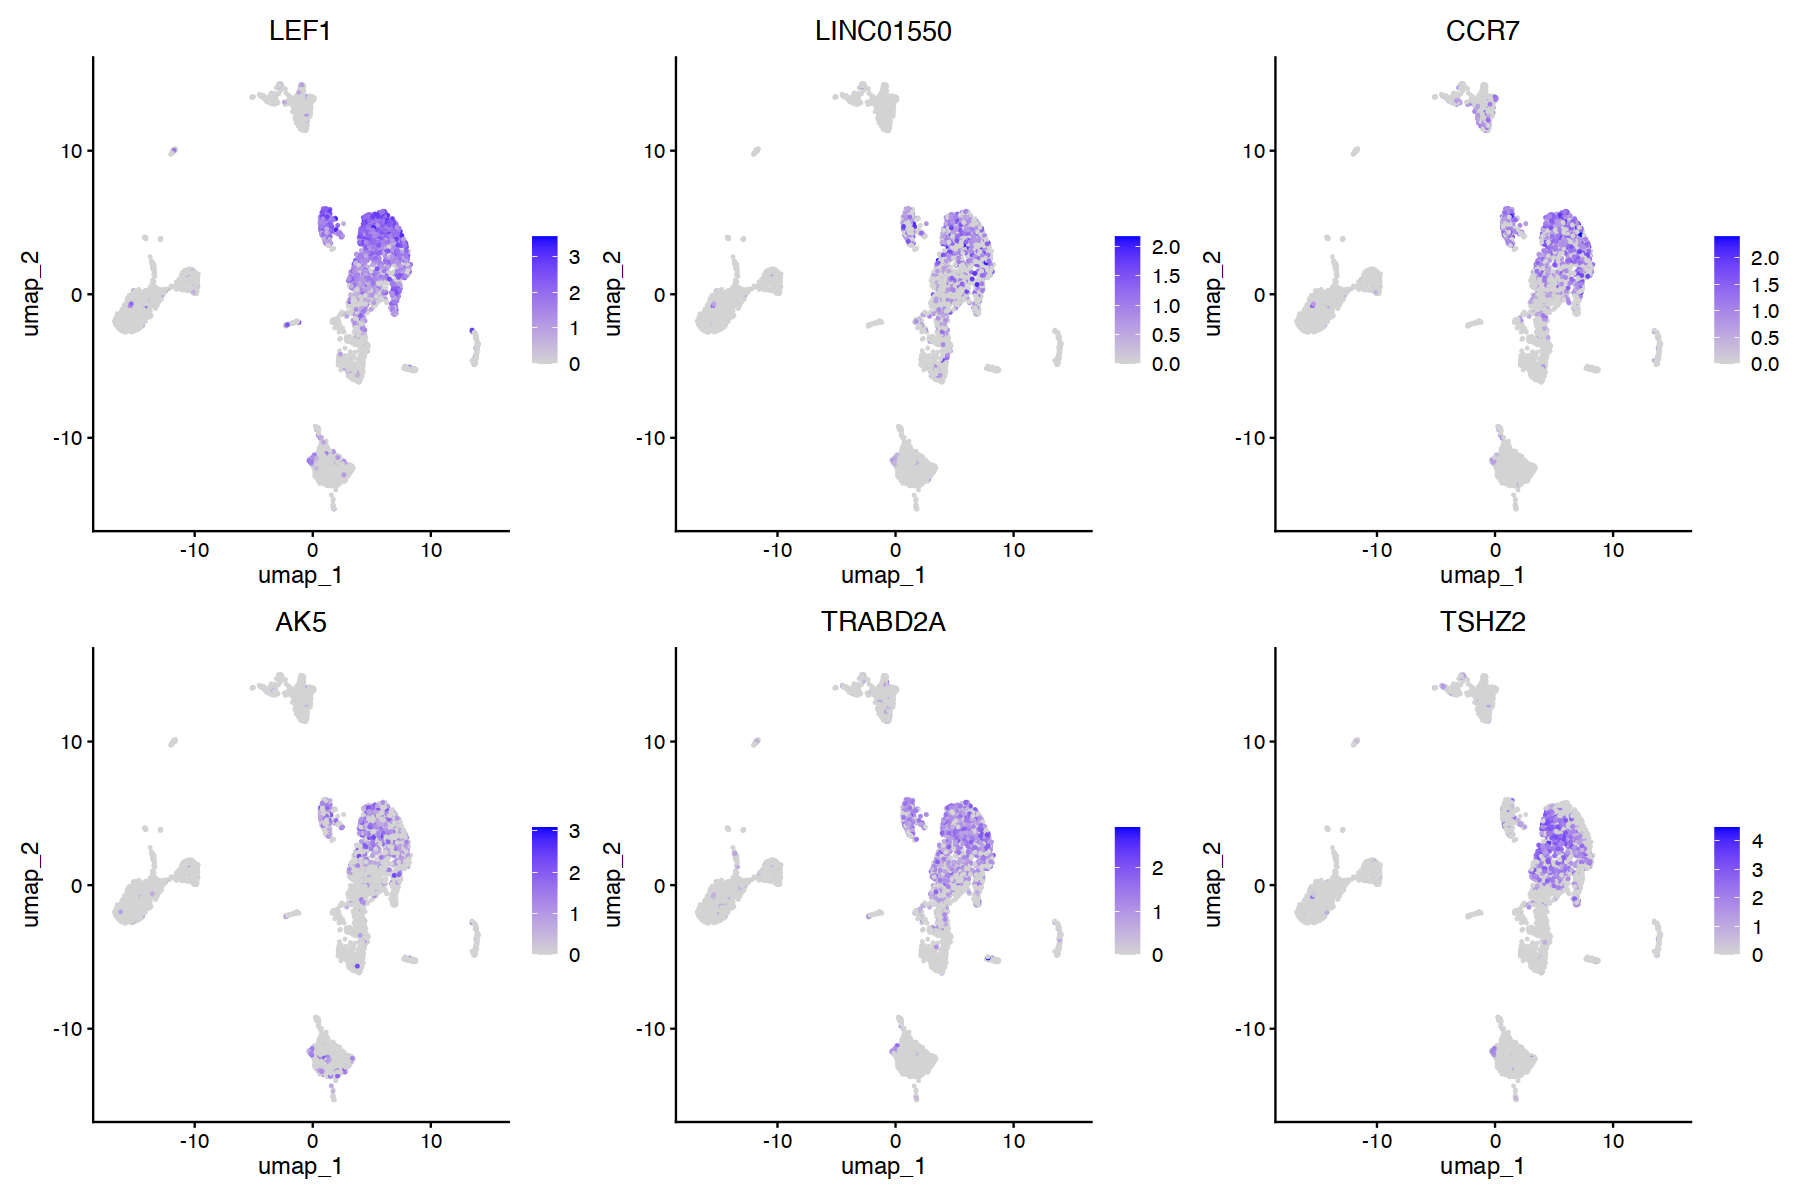

In [66]:
options(repr.plot.width=15, repr.plot.height=10)
p <- FeaturePlot(sce, features = mks[cluster==0]$gene[1:6], reduction='umap', ncol=3)
p

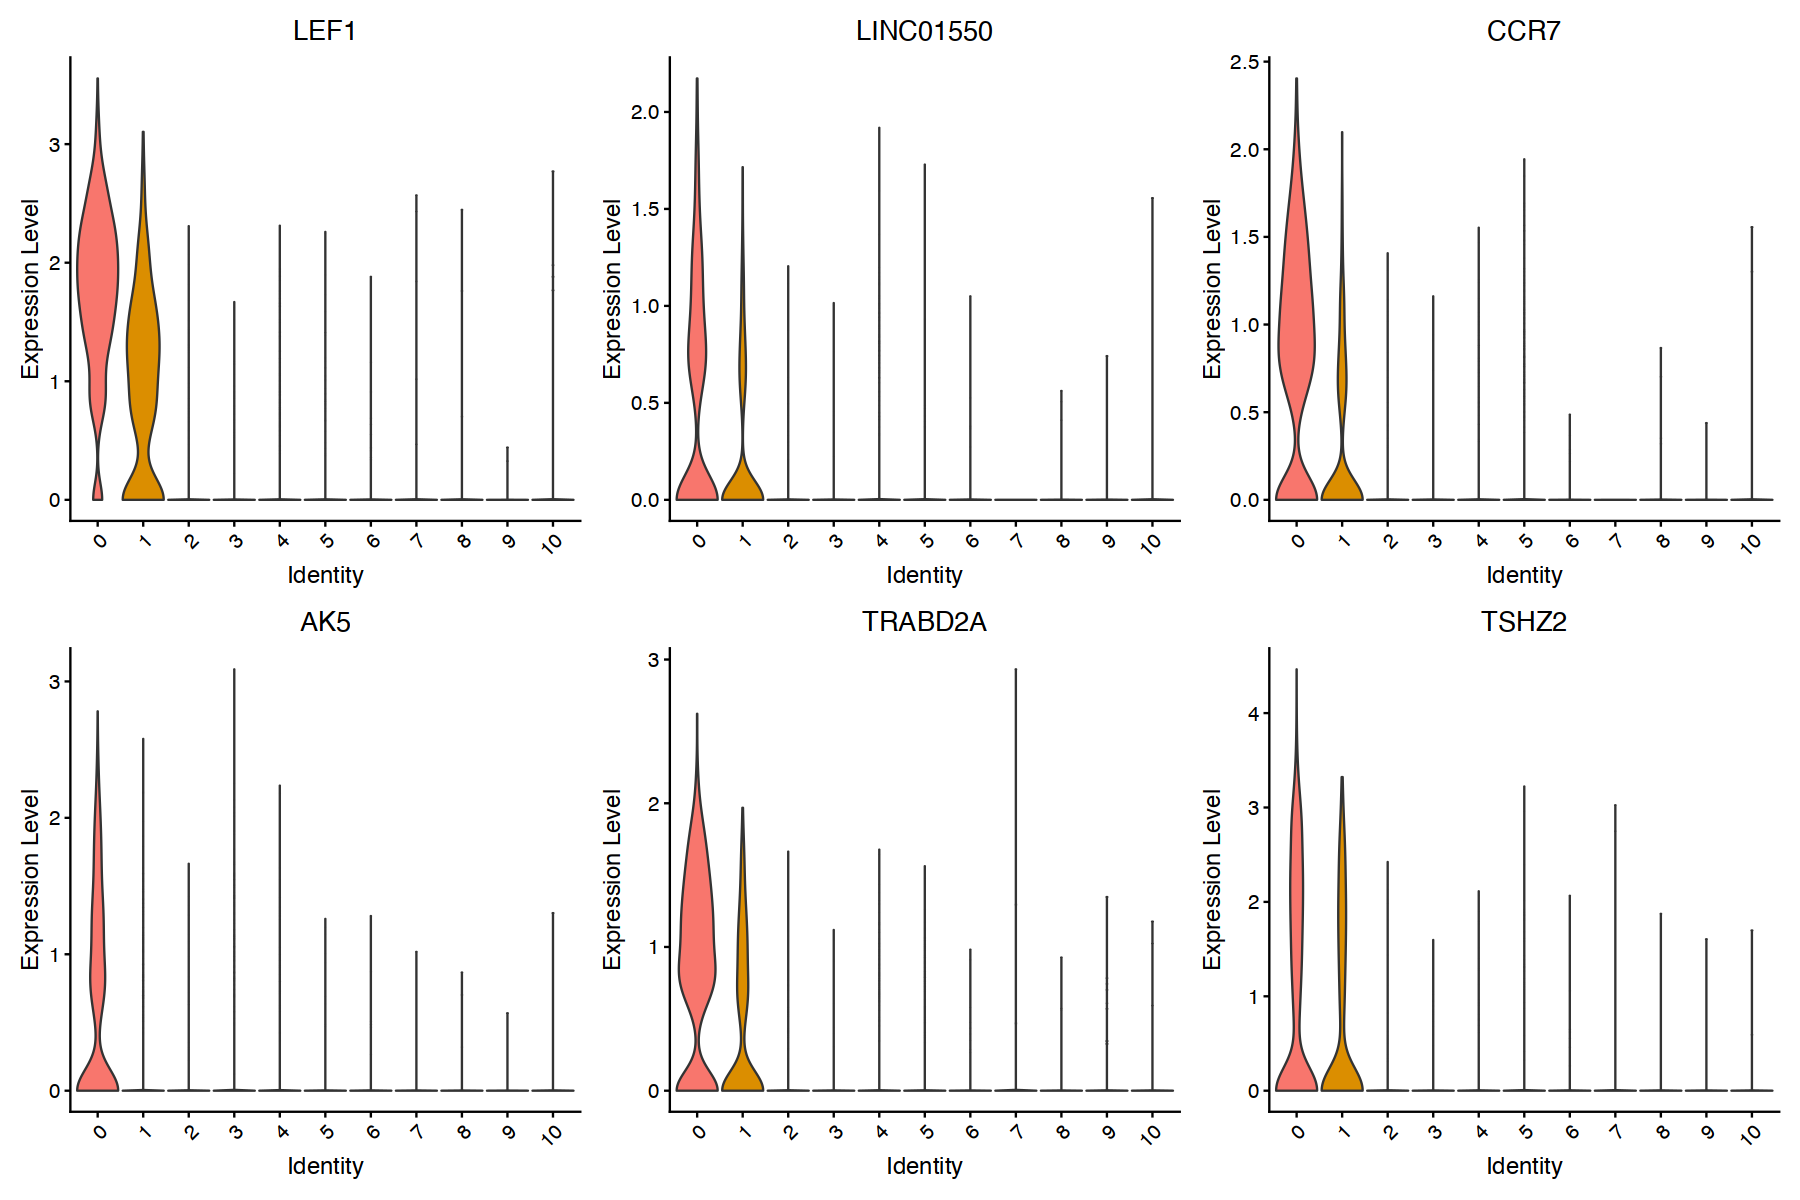

In [70]:
options(repr.plot.width=15, repr.plot.height=10)
p <- VlnPlot(sce, features = mks[cluster==0]$gene[1:6], ncol=3, pt.size=0)
p

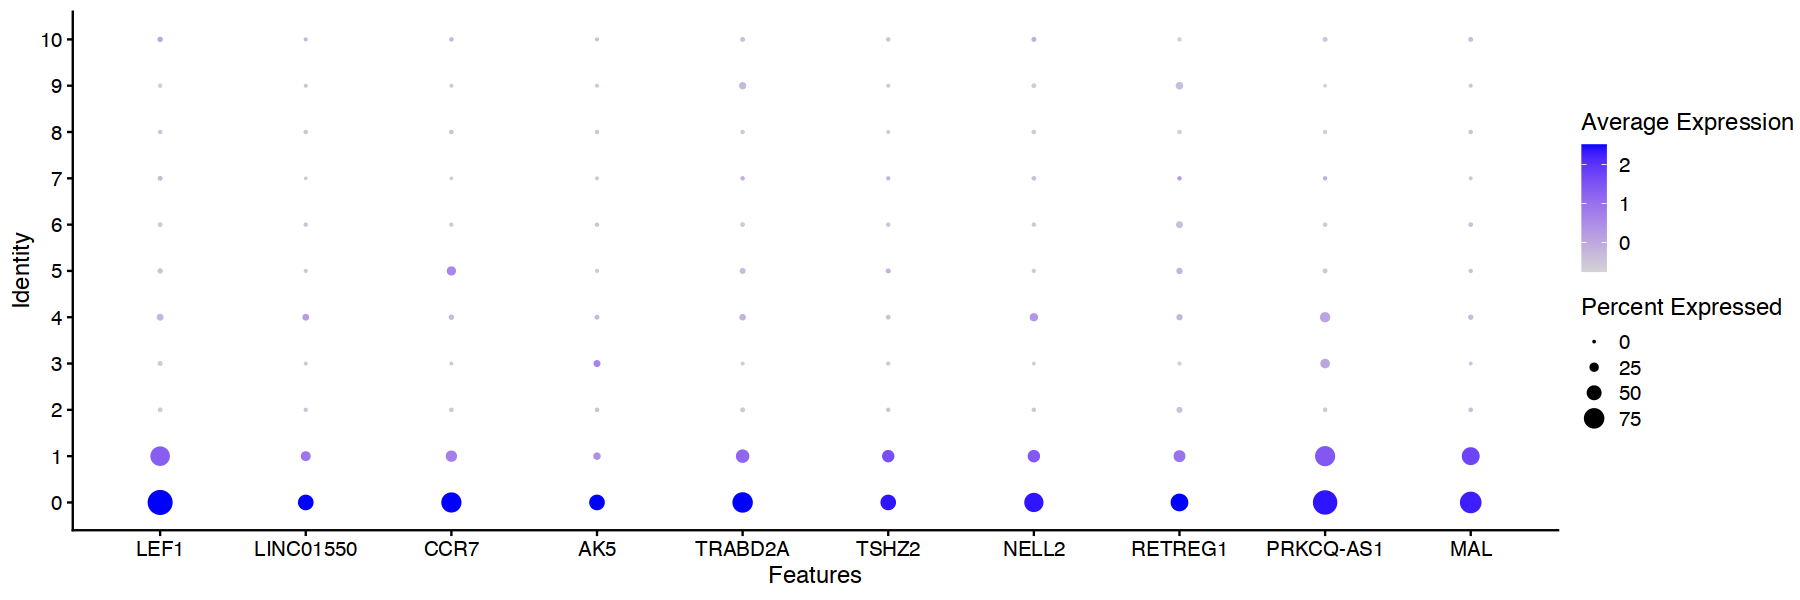

In [67]:
options(repr.plot.width=15, repr.plot.height=5)
DotPlot(sce, features = mks[cluster==0]$gene)

# 细胞注释

In [68]:
suppressMessages(library(SingleR))
suppressMessages(library(celldex))

Warning message:
“package ‘BiocGenerics’ was built under R version 4.2.1”
Warning message:
“package ‘S4Vectors’ was built under R version 4.2.2”
Warning message:
“package ‘IRanges’ was built under R version 4.2.1”
Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.2.2”
Warning message:
“package ‘Biobase’ was built under R version 4.2.1”
Warning message:
“multiple methods tables found for ‘aperm’”
Warning message:
“replacing previous import ‘BiocGenerics::aperm’ by ‘DelayedArray::aperm’ when loading ‘SummarizedExperiment’”


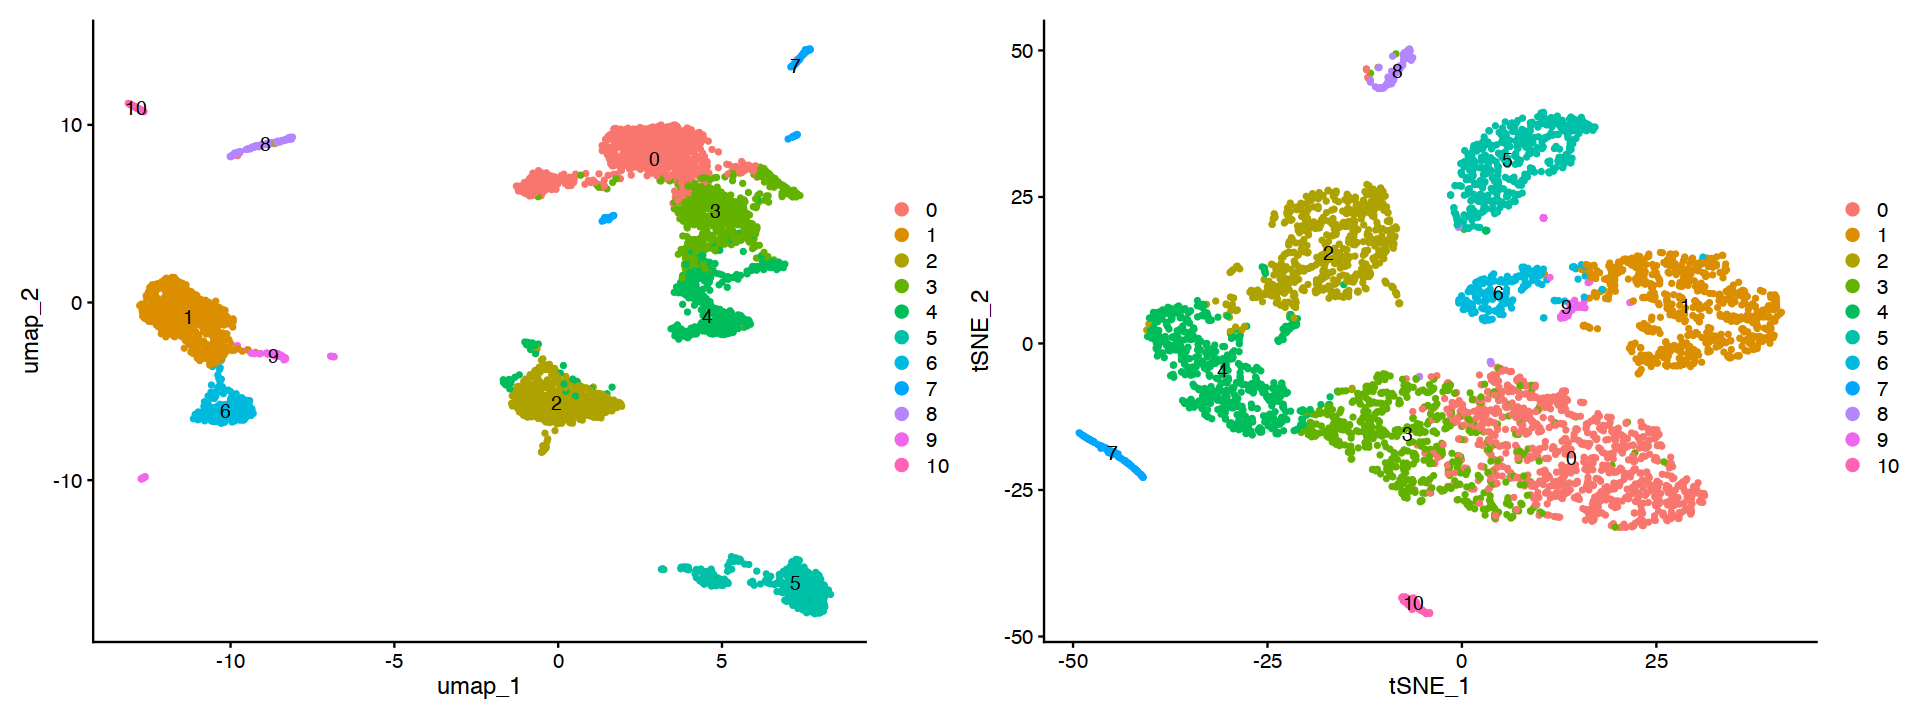

In [69]:
options(repr.plot.width=16, repr.plot.height=6)
p1 <- DimPlot(sce, reduction = 'umap', label=T, pt.size=1)
p2 <- DimPlot(sce, reduction = 'tsne', label=T, pt.size=1)
p1+p2

In [70]:
#refdata <- celldex::BlueprintEncodeData()
refdata <- readRDS('data/SingleRef/ref.HumanPrimaryCellAtlasData.Rds')

In [71]:
expr <- GetAssayData(sce, assay = 'RNA', layer = 'data')

In [72]:
pred <- suppressWarnings(SingleR(test=expr, ref=refdata, labels=refdata$label.main, clusters=sce$seurat_clusters))

In [73]:
sce$cellType <- pred$labels[sce$seurat_clusters]

In [74]:
pred <- suppressWarnings(SingleR(test=expr, ref=refdata, labels=refdata$label.fine, clusters=sce$seurat_clusters))
sce$cellTypeFine <- pred$labels[sce$seurat_clusters]
sce$cellTypeFinePrune <- pred$pruned.labels[sce$seurat_clusters]

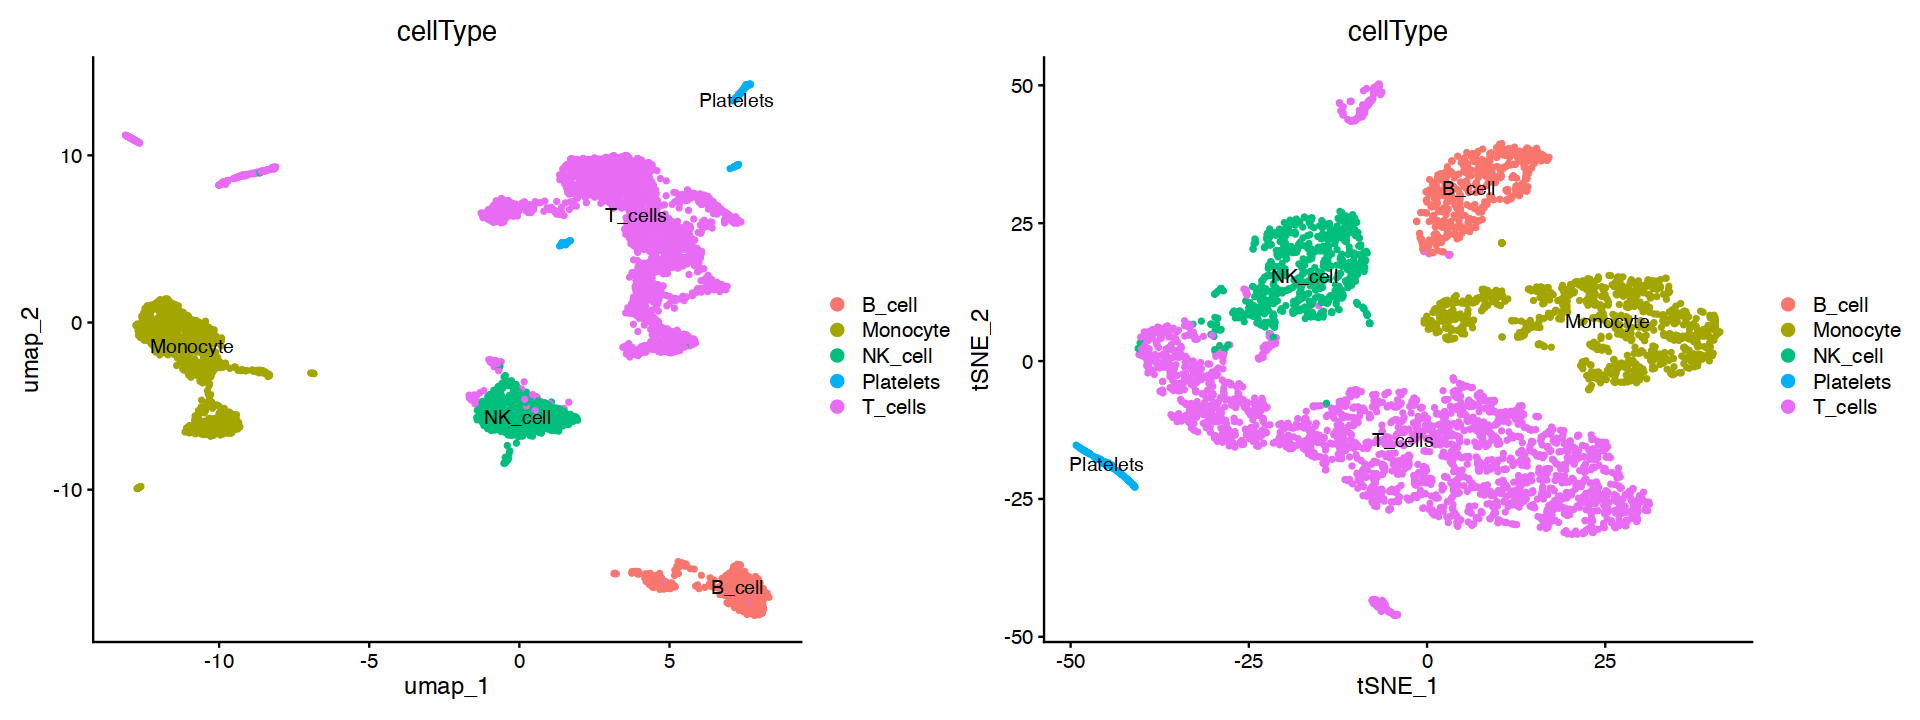

In [76]:
DimPlot(sce, reduction = 'umap', group.by = 'cellType', pt.size=1, label=T) +
DimPlot(sce, reduction = 'tsne', group.by = 'cellType', pt.size=1, label=T)

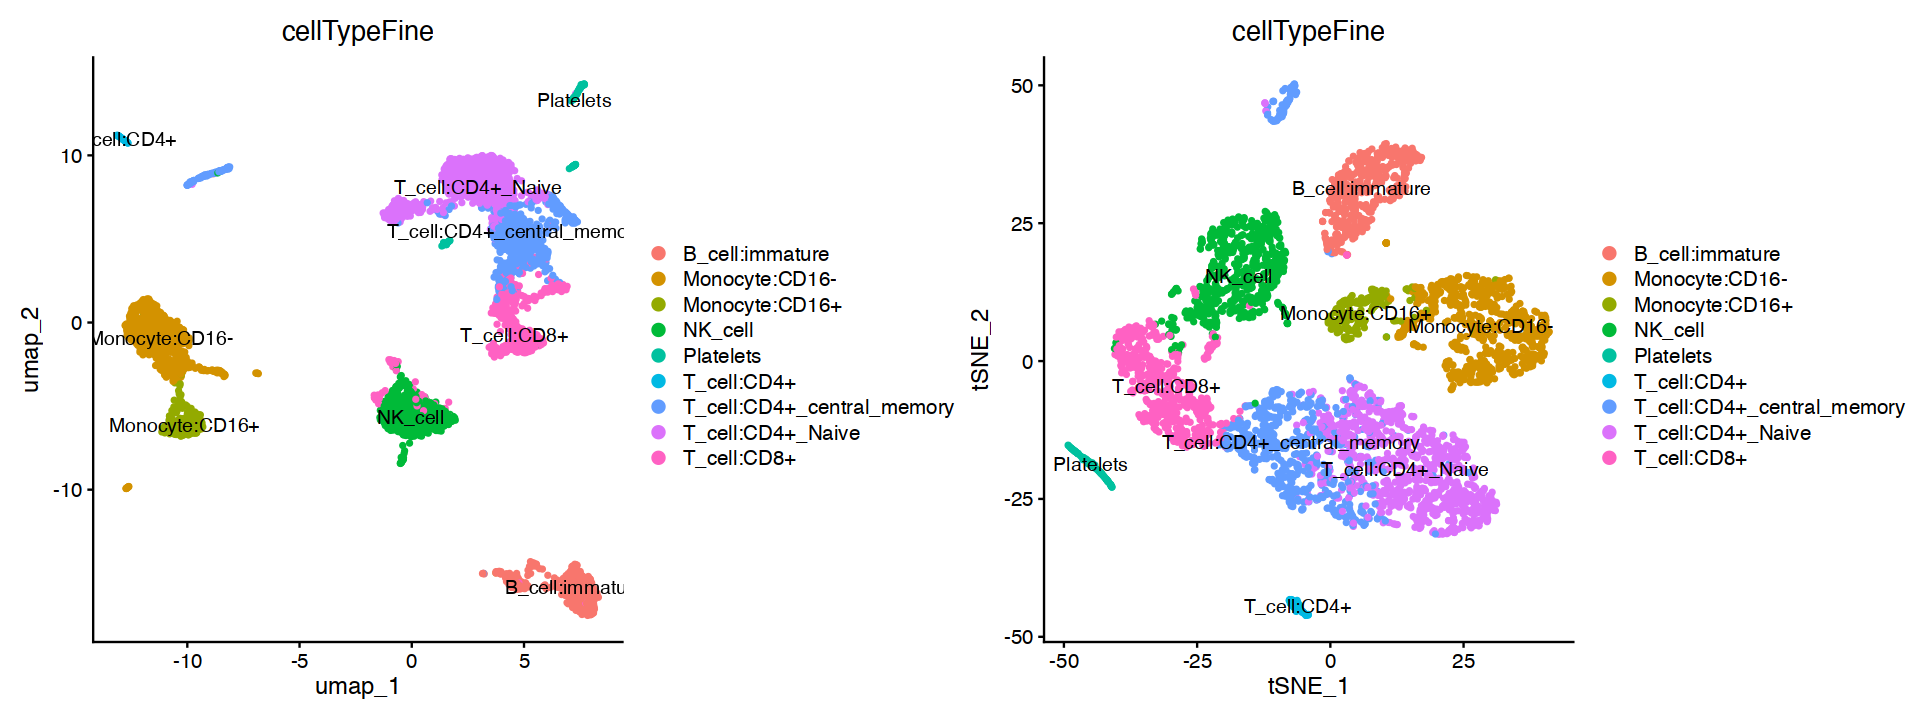

In [77]:
DimPlot(sce, reduction = 'umap', group.by = 'cellTypeFine', pt.size=1, label=T) +
DimPlot(sce, reduction = 'tsne', group.by = 'cellTypeFine', pt.size=1, label=T)

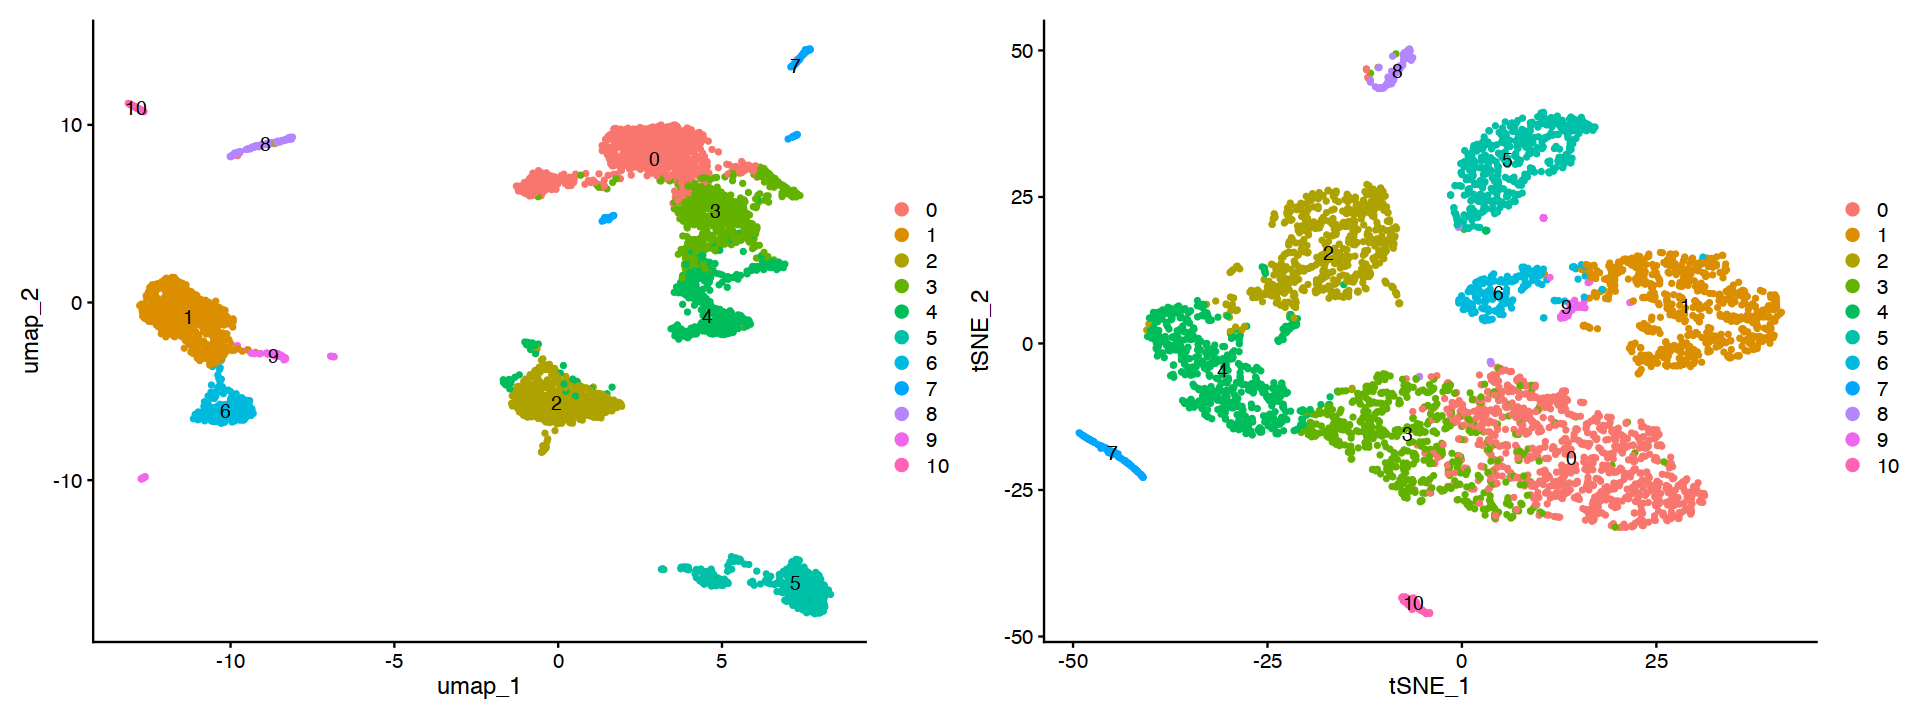

In [78]:
options(repr.plot.width=16, repr.plot.height=6)
p1 <- DimPlot(sce, reduction = 'umap', label=T, pt.size=1)
p2 <- DimPlot(sce, reduction = 'tsne', label=T, pt.size=1)
p1+p2

In [126]:
imm <- c('PTPRC')
mye <- c('LYZ', 'CD68')
Bcell <- c('CD79A','MS4A1')
Tcell <- c('CD3D','CD3E')
CD8 <- c('CD8A', 'CD8B')
CD4 <- c("CD4", "IL7R")
NK <- c('GNLY','NKG7')
neu <- c('LST1', 'S100A8', 'S100A9')
mono <- c('CD14', 'VCAN','FCGR3A')
HSC <- c('GATA2')
Erythrocyte <- c('HBA1','HBD')
Platelets <- c('PPBP','GP9', 'PF4')

In [127]:
genes <- c(imm, mye, Bcell, Tcell, NK, CD4, CD8, mono, neu,Platelets,Erythrocyte, HSC, 'CCR3')

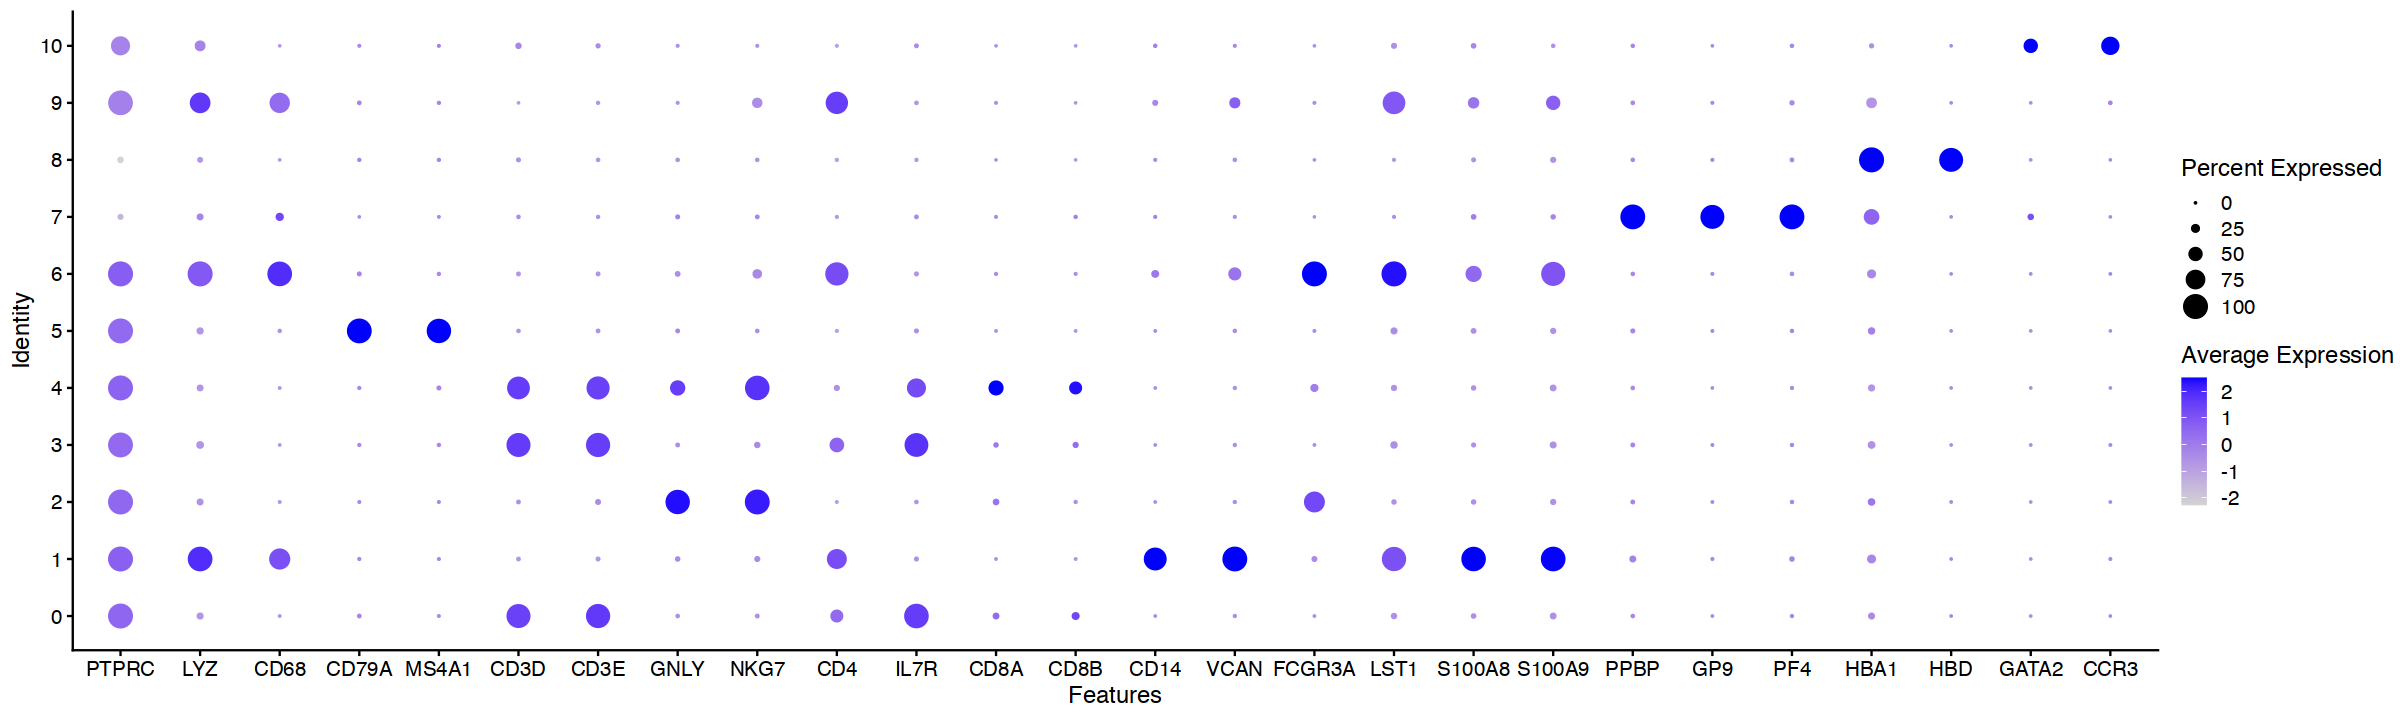

In [134]:
options(repr.plot.width=20, repr.plot.height=6)
Idents(sce) <- 'seurat_clusters'
DotPlot(sce, features = genes)

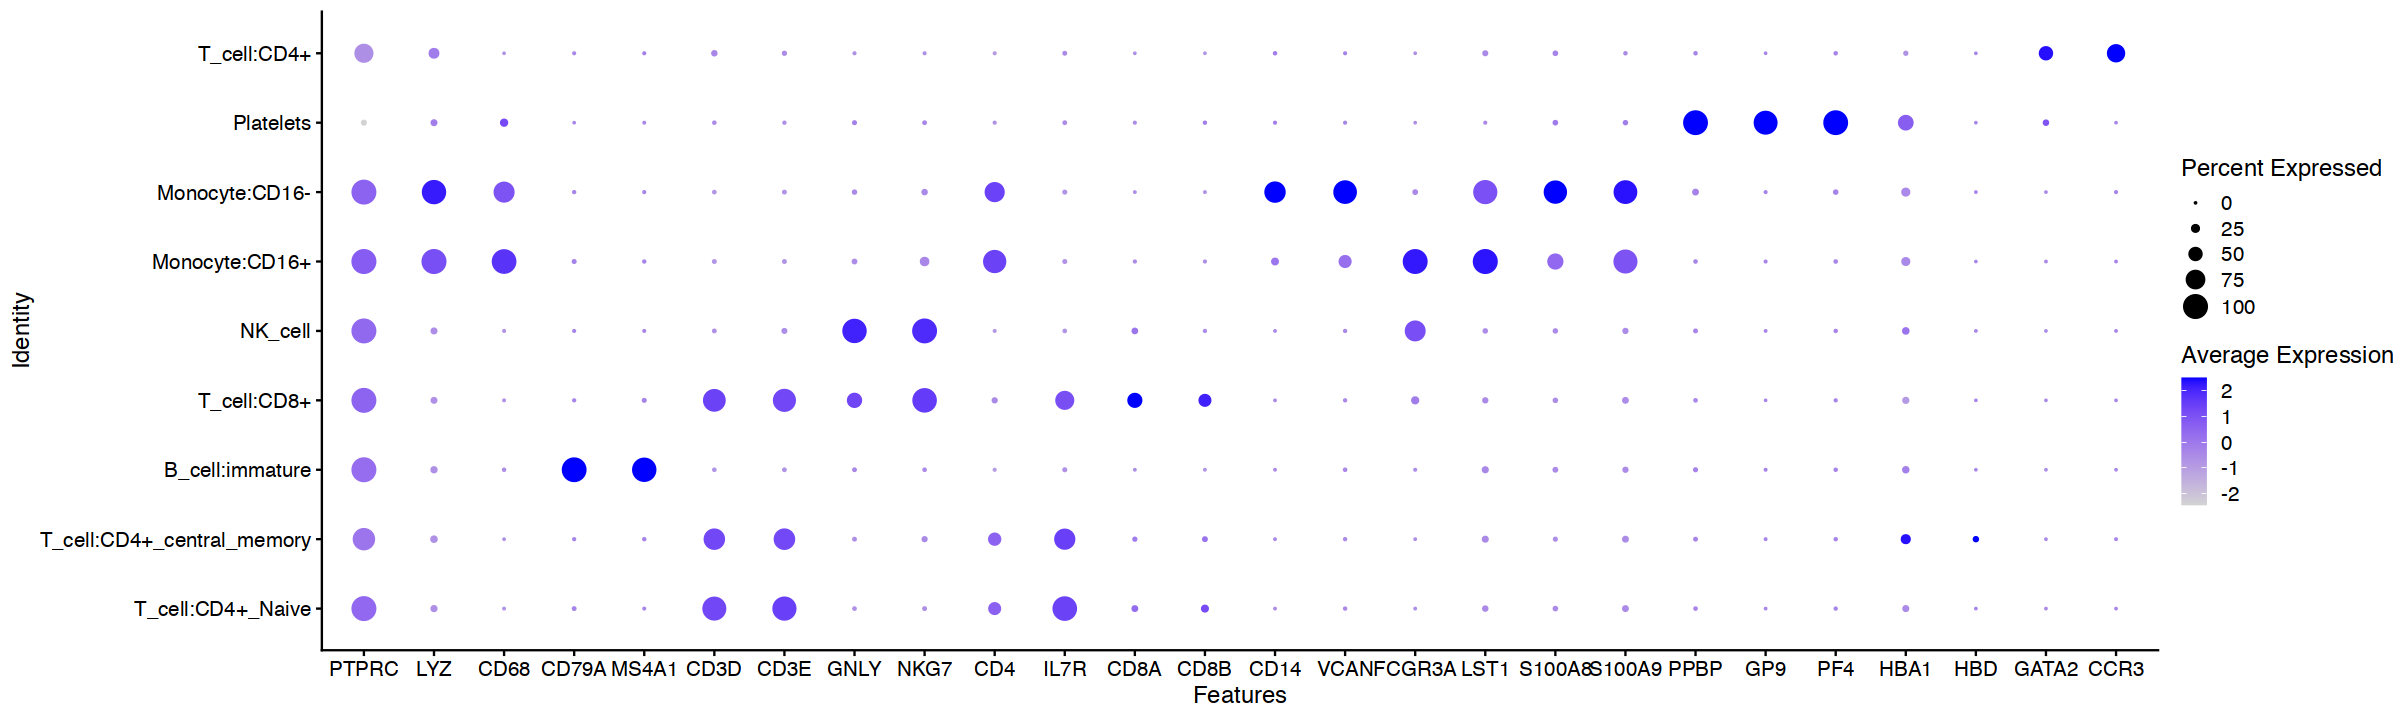

In [129]:
options(repr.plot.width=20, repr.plot.height=6)
Idents(sce) <- 'cellTypeFine'
DotPlot(sce, features = genes)

In [135]:
annoI <- c(
    '0'='CD4+ Cell',
    '1'='CD16- Mono',
    '2'='NK',
    '3'='CD4+ Cell',
    '4'='CD8+ Cell',
    '5'='B Cell',
    '6'='CD16+ Mono',
    '7'='Platelets',
    '8'='Erythrocyte',
    '9'='CD16- Mono',
    '10'='Eosinophils'
)

In [159]:
annoCell <- function(sce, annoI, annoII=FALSE){
    annotation_I <- annoI[as.character(sce$seurat_clusters)]
    names(annotation_I) <- NULL
    sce$annotation_I <- annotation_I
    if(annoII){
        annotation_II <- annoII[as.character(sce$seurat_clusters)]
        names(annotation_II) <- NULL
        sce$annotation_II <- annotation_II
    }
    return(sce)
}

In [160]:
sce <- annoCell(sce, annoI)

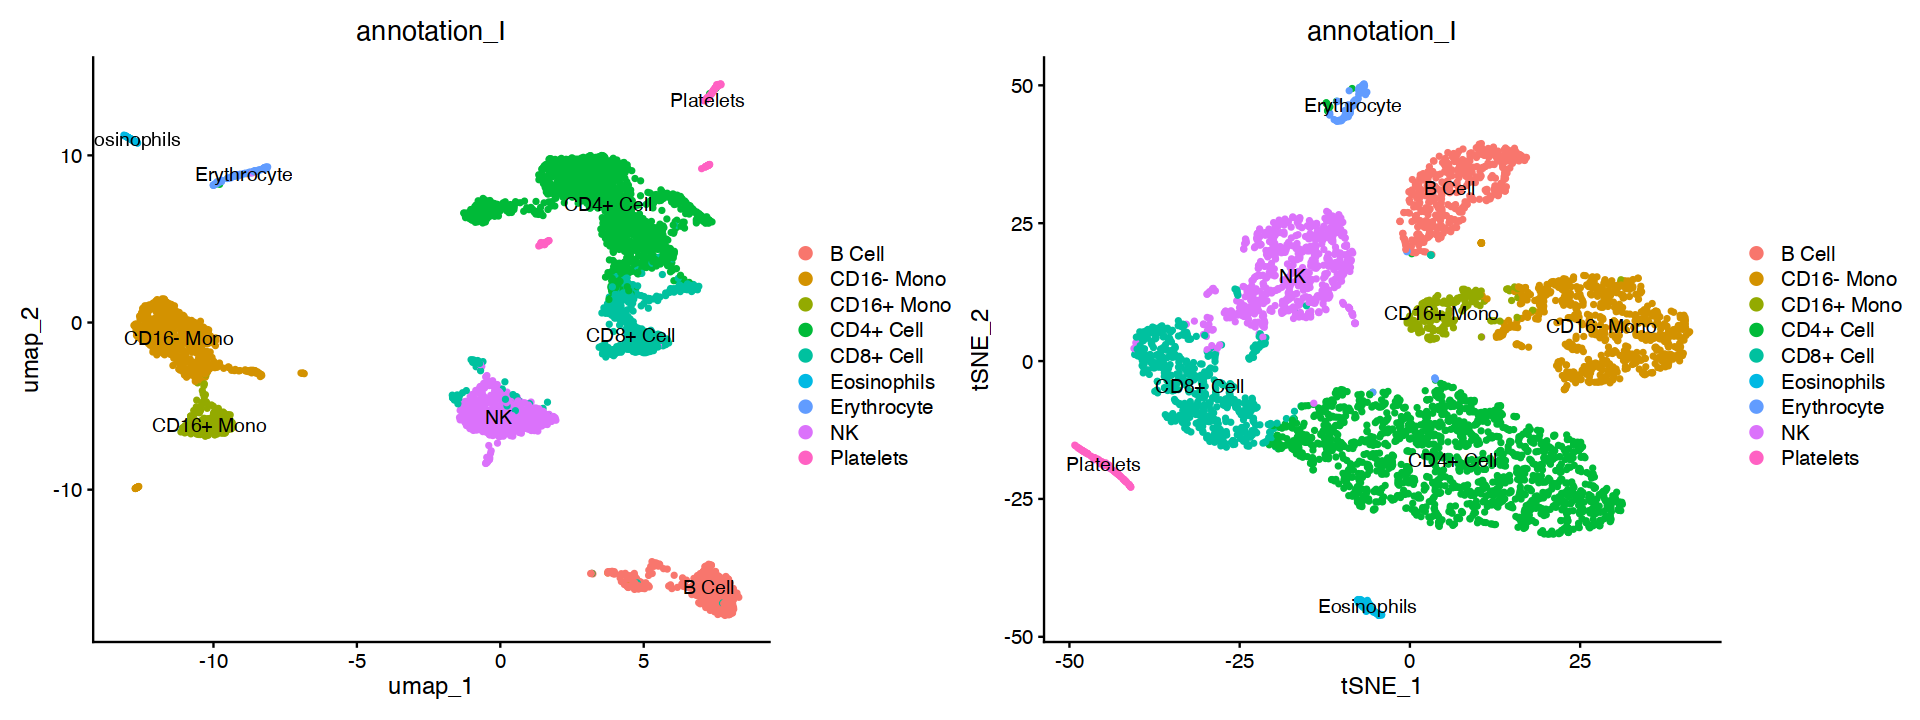

In [163]:
DimPlot(sce, reduction = 'umap', group.by = 'annotation_I', pt.size=1, label=T) +
DimPlot(sce, reduction = 'tsne', group.by = 'annotation_I', pt.size=1, label=T)

In [161]:
saveRDS(sce, 'data/sce.RDS')

In [3]:
sce <- readRDS('data/sce.RDS')

# 细胞周期

In [141]:
cc.genes

$s.genes
 [1] "MCM5"     "PCNA"     "TYMS"     "FEN1"     "MCM2"     "MCM4"    
 [7] "RRM1"     "UNG"      "GINS2"    "MCM6"     "CDCA7"    "DTL"     
[13] "PRIM1"    "UHRF1"    "MLF1IP"   "HELLS"    "RFC2"     "RPA2"    
[19] "NASP"     "RAD51AP1" "GMNN"     "WDR76"    "SLBP"     "CCNE2"   
[25] "UBR7"     "POLD3"    "MSH2"     "ATAD2"    "RAD51"    "RRM2"    
[31] "CDC45"    "CDC6"     "EXO1"     "TIPIN"    "DSCC1"    "BLM"     
[37] "CASP8AP2" "USP1"     "CLSPN"    "POLA1"    "CHAF1B"   "BRIP1"   
[43] "E2F8"    

$g2m.genes
 [1] "HMGB2"   "CDK1"    "NUSAP1"  "UBE2C"   "BIRC5"   "TPX2"    "TOP2A"  
 [8] "NDC80"   "CKS2"    "NUF2"    "CKS1B"   "MKI67"   "TMPO"    "CENPF"  
[15] "TACC3"   "FAM64A"  "SMC4"    "CCNB2"   "CKAP2L"  "CKAP2"   "AURKB"  
[22] "BUB1"    "KIF11"   "ANP32E"  "TUBB4B"  "GTSE1"   "KIF20B"  "HJURP"  
[29] "CDCA3"   "HN1"     "CDC20"   "TTK"     "CDC25C"  "KIF2C"   "RANGAP1"
[36] "NCAPD2"  "DLGAP5"  "CDCA2"   "CDCA8"   "ECT2"    "KIF23"   "HMMR"   
[43] "AURKA"   "PSRC1"   "ANLN"    "LBR"     "CKAP5"   "CENPE"   "CTCF"   
[50] "NEK2"    "G2E3"    "GAS2L3"  "CBX5"    "CENPA"

In [140]:
sce <- CellCycleScoring(sce, s.features = cc.genes$s.genes,
                        g2m.features = cc.genes$g2m.genes)

Warning message:
“The following features are not present in the object: MLF1IP, E2F8, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, NEK2, not searching for symbol synonyms”


In [143]:
head(sce, 3)

orig.ident    nCount_RNA nFeature_RNA percent.mt
AAACCCATCAGATGCT-1 SeuratProject  8474      3244         3.89077903
AAACGAAGTCGTAATC-1 SeuratProject 14681       211         0.02717945
AAACGAAGTTGCCAAT-1 SeuratProject  6787      2868         5.04201681
                   percent.ribo RNA_snn_res.0.2 seurat_clusters cellType
AAACCCATCAGATGCT-1 26.0751985   0               0               T_cells 
AAACGAAGTCGTAATC-1  0.2446151   8               8               T_cells 
AAACGAAGTTGCCAAT-1 37.3256995   0               0               T_cells 
                   cellTypeFine               cellTypeFinePrune         
AAACCCATCAGATGCT-1 T_cell:CD4+_Naive          T_cell:CD4+_Naive         
AAACGAAGTCGTAATC-1 T_cell:CD4+_central_memory T_cell:CD4+_central_memory
AAACGAAGTTGCCAAT-1 T_cell:CD4+_Naive          T_cell:CD4+_Naive         
                   S.Score     G2M.Score    Phase
AAACCCATCAGATGCT-1  0.08271546 -0.006386490 S    
AAACGAAGTCGTAATC-1 -0.01131228 -0.008031259 G1   
AAACGAAGTTGCCAAT-1  0.07198342  0.025602737 S

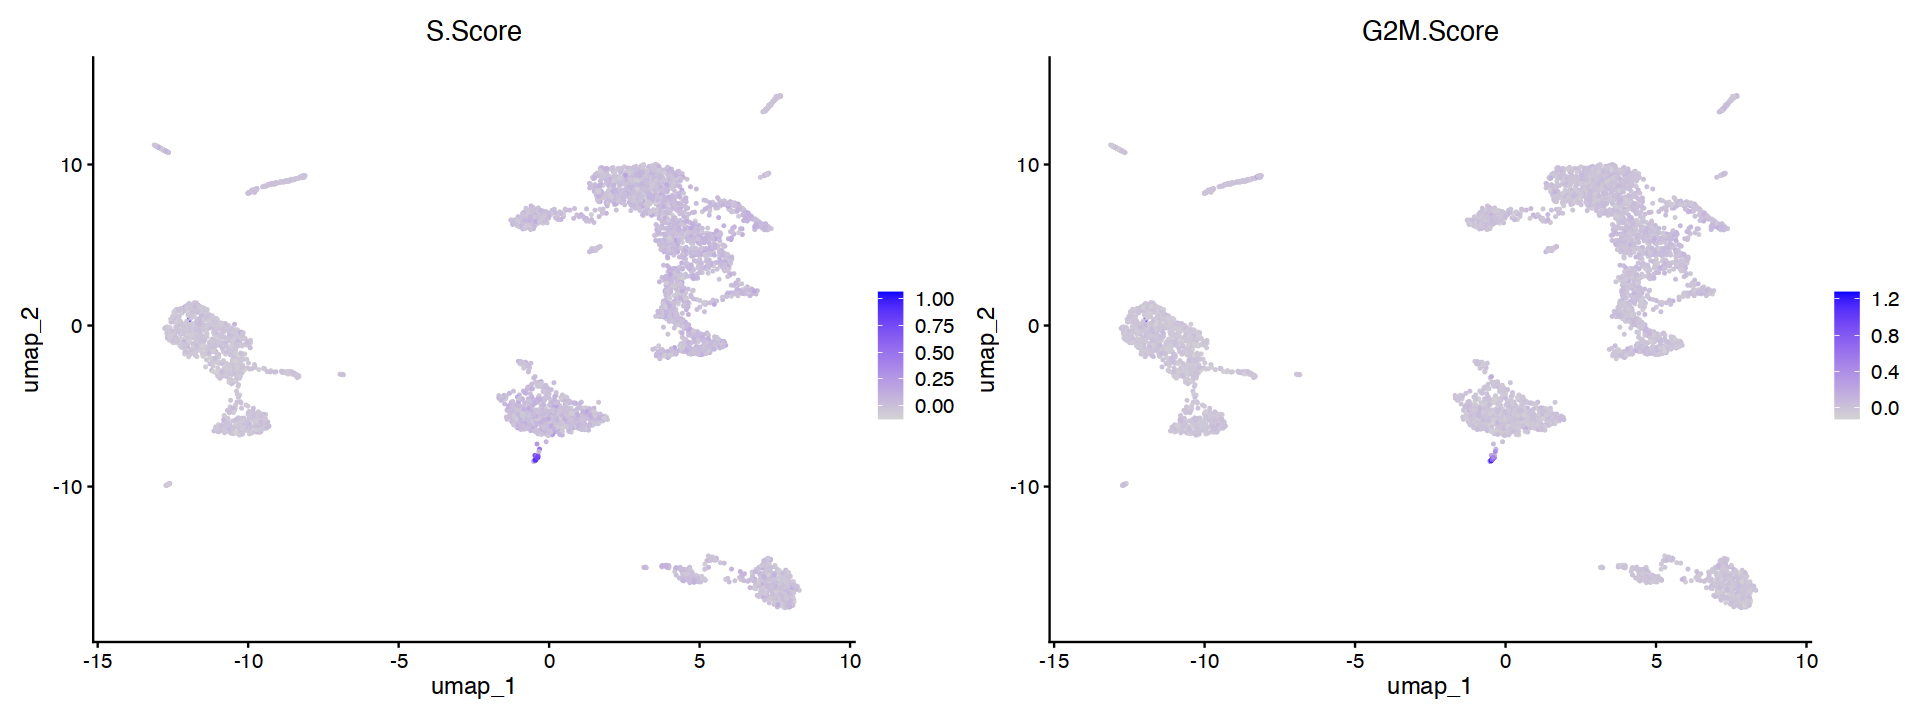

In [145]:
FeaturePlot(sce, features = c('S.Score', 'G2M.Score'))

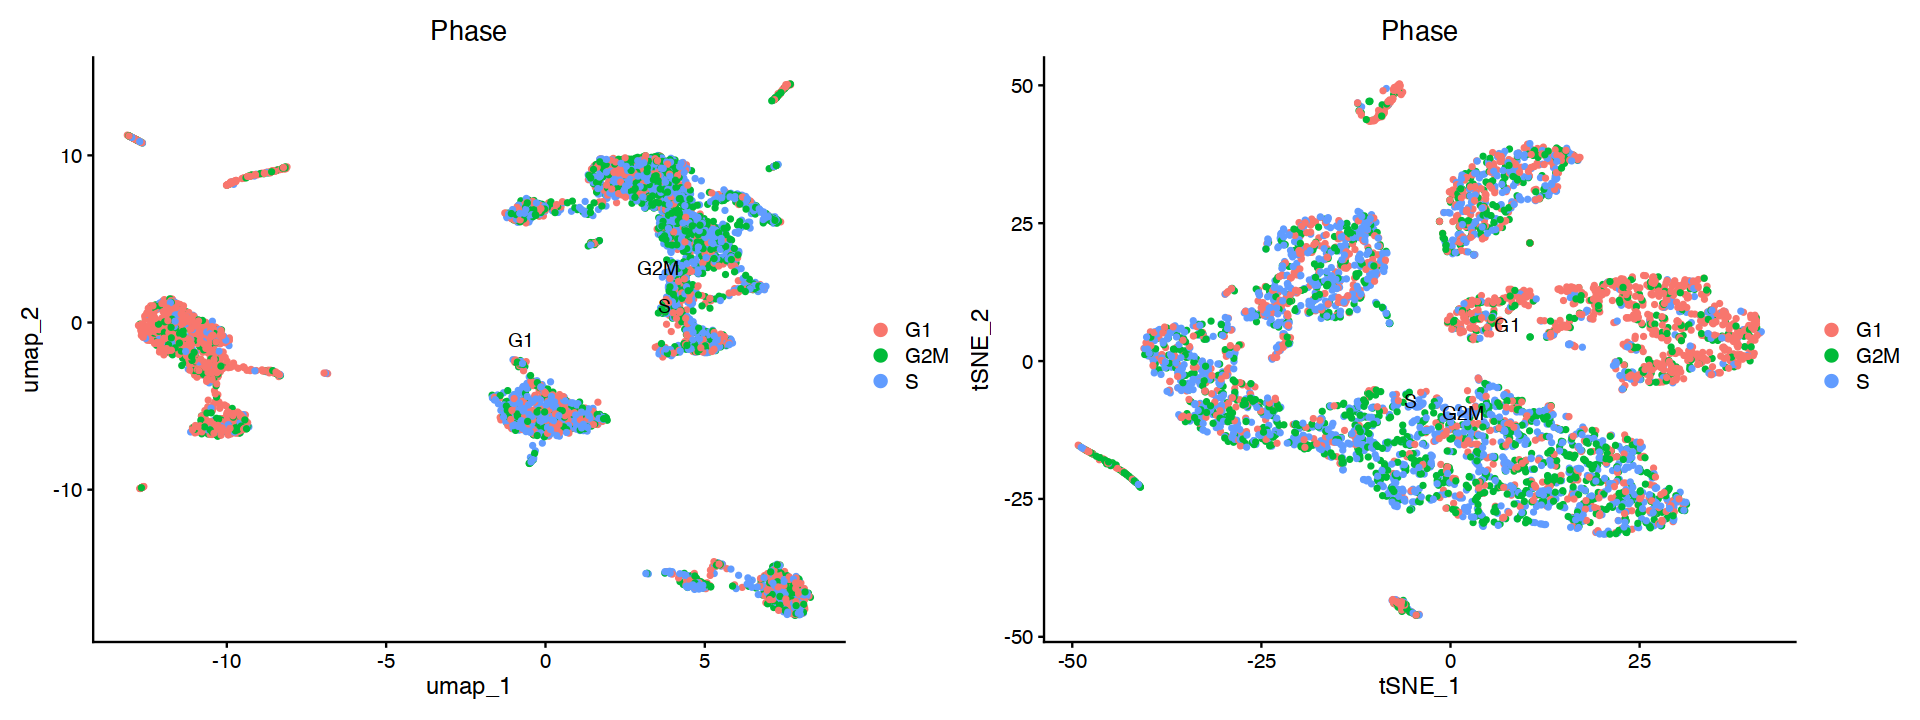

In [144]:
options(repr.plot.width=16, repr.plot.height=6)
p1 <- DimPlot(sce, reduction = 'umap', group.by='Phase', label=T, pt.size=1)
p2 <- DimPlot(sce, reduction = 'tsne', group.by='Phase', label=T, pt.size=1)
p1+p2

In [ ]:
# sce <- ScaleData(sce, vars.to.regress=c('S.Score', 'G2M.Score')

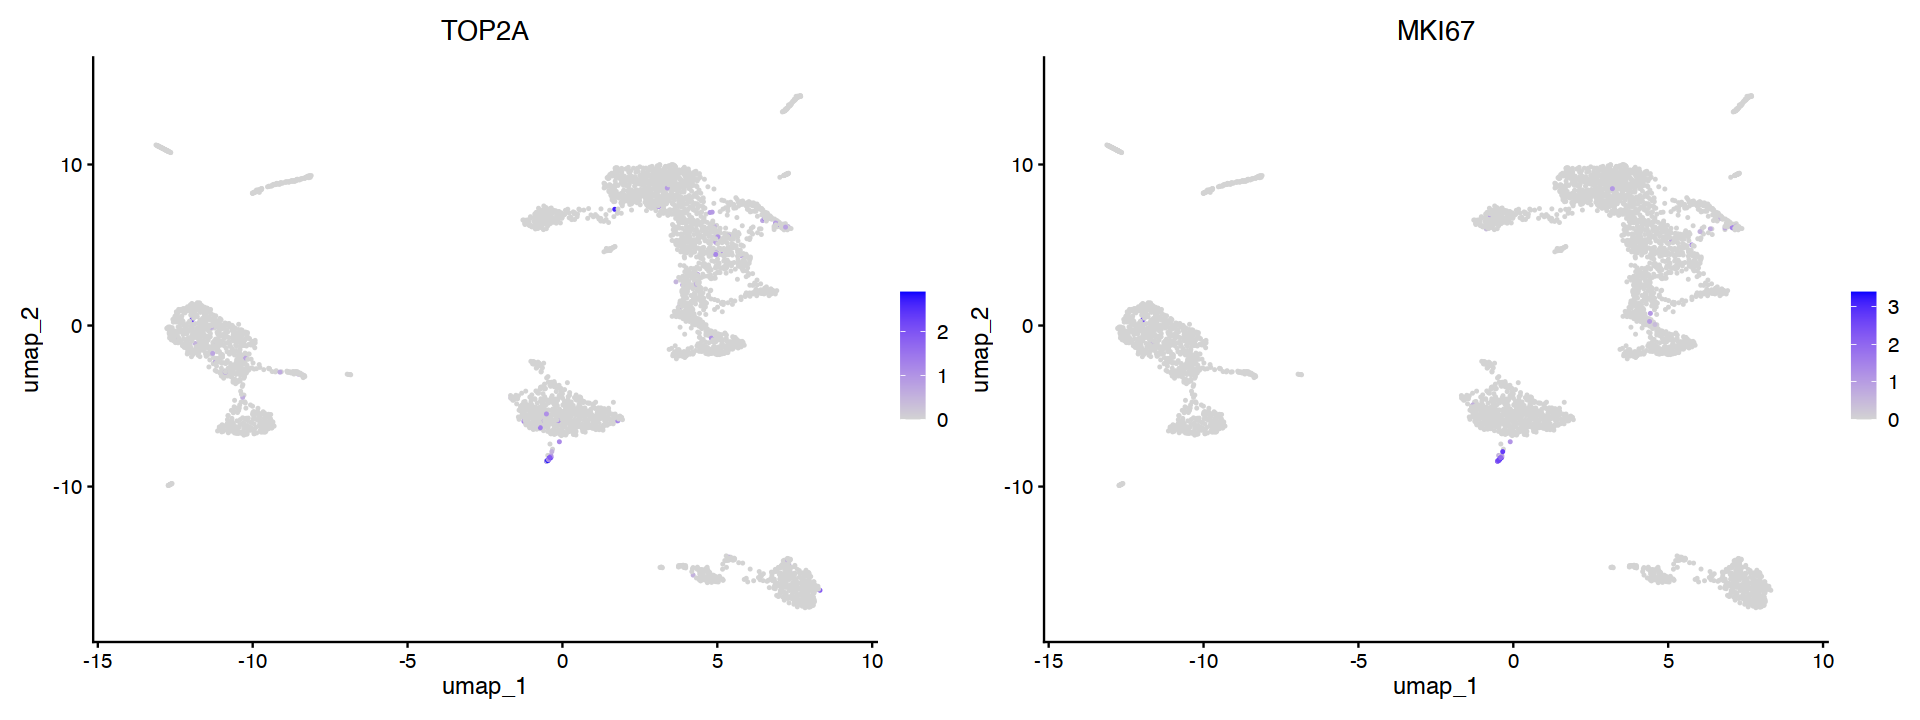

In [162]:
FeaturePlot(sce, features = c('TOP2A', 'MKI67'))